In [2]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import scanpy as sc

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics, preprocessing
from sklearn.metrics import adjusted_rand_score, jaccard_score, silhouette_score, adjusted_mutual_info_score, calinski_harabasz_score

import csv
import gzip
import os
import scipy.io

# Reading the data

At first, we have to convert the 10X data into AnnData format.

In [3]:
def read_10X_data(matrix_dir: str, prefix: str):
    mat = scipy.io.mmread(os.path.join(matrix_dir, prefix+"matrix.mtx.gz"))
    
    features_path = os.path.join(matrix_dir, prefix+"genes.tsv.gz")
    feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, "rt", encoding="utf-8"), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(gzip.open(features_path, "rt", encoding="utf-8"), delimiter="\t")]
    barcodes_path = os.path.join(matrix_dir, prefix+"barcodes.tsv.gz")
    barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, "rt", encoding="utf-8"), delimiter="\t")]
    
    var = pd.DataFrame(data={"ID": feature_ids,"Name": gene_names})
    obs = pd.DataFrame(data={"Name": barcodes})
    adata = sc.AnnData(X = mat.transpose(),
                       var=var,
                       obs=obs)
    
    return adata

In [4]:
home_dir = '/home/jafar_isbarov/Desktop/scRNA-seq/paper_2/GSE143888_RAW/'

stages = ['UA',
          '11dpa',
          '12dpa',
          '14dpa',
          '17dpa']

prefixes = ['GSM4276219_UA_BRI232_',
            'GSM4276220_11dpa_BRI230_',
            'GSM4276221_12dpa_BRI074_',
            'GSM4276222_14dpa_BRI206_',
            'GSM4276223_17dpa_BRI231_']

adatas = []
for final_directory, prefix in zip(stages, prefixes):
    adatas.append(read_10X_data(home_dir+final_directory, prefix=prefix))

/home/jafar_isbarov/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


We should also read the cell types data.

In [5]:
def read_mmc2(sheet_name: str):
    cell_types_11dpa = pd.read_excel('mmc2.xlsx', sheet_name=sheet_name)
    cell_types_11dpa = cell_types_11dpa.drop([0,1])
    new_header = cell_types_11dpa.iloc[0]
    cell_types_11dpa = cell_types_11dpa[1:]
    cell_types_11dpa.columns = new_header
    cell_types_11dpa.index = np.arange(len(cell_types_11dpa))
    
    return cell_types_11dpa

In [6]:
sheet_names = ['E. Unamputated', 'A. 11dpa', 'B. 12dpa', 'C. 14dpa', 'D. 17dpa']
cell_types_hvgs = []

for sheet_name in sheet_names:
    cell_types_hvgs.append(read_mmc2(sheet_name))

Lastly, we will record marker genes in a single list, to be used later.

In [7]:
marker_genes = ['Bglap', 'Krt14', 'Plp1', 'Lyz2', 'Pecam1', 'Rgs5', 'Cd3g', 'Prrx1']

# UA
## Pre-processing

In [8]:
adata_ua = adatas[0].copy()
adata_ua.var_names = adata_ua.var['Name']
adata_ua.var_names_make_unique()

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_ua.X = adata_ua.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_ua, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_ua, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_ua.var['mt'] = adata_ua.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_ua, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Text(0.5, 1.0, 'percentage of mitochondrial counts')

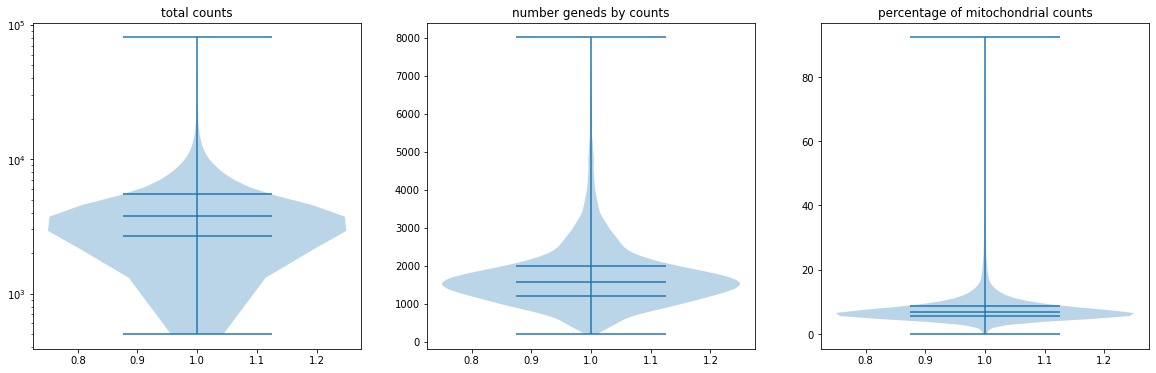

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axs[0].violinplot(adata_ua.obs['total_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[0].set_yscale('log')
axs[0].set_title('total counts')
axs[1].violinplot(adata_ua.obs['n_genes_by_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[1].set_title('number geneds by counts')
axs[2].violinplot(adata_ua.obs['pct_counts_mt'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[2].set_title('percentage of mitochondrial counts')

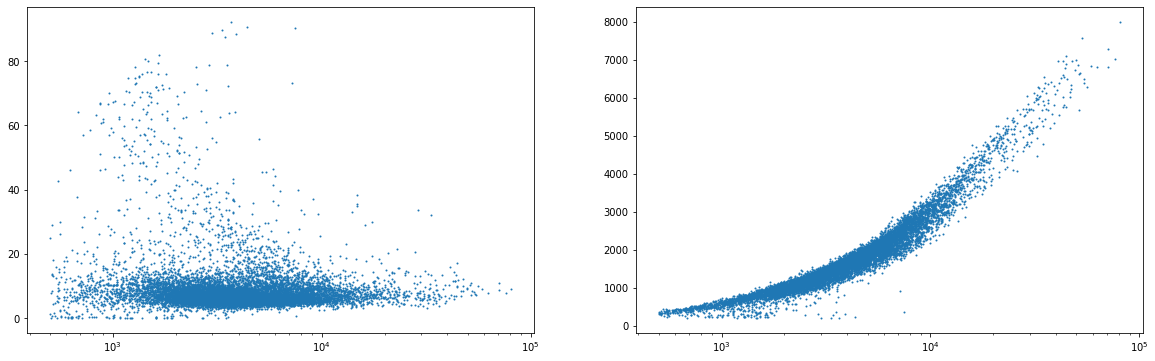

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axs[0].scatter(x=adata_ua.obs['total_counts'], y = adata_ua.obs['pct_counts_mt'], s=1)
axs[0].set_xscale('log')
axs[1].scatter(x=adata_ua.obs['total_counts'], y = adata_ua.obs['n_genes_by_counts'], s=1)
axs[1].set_xscale('log')

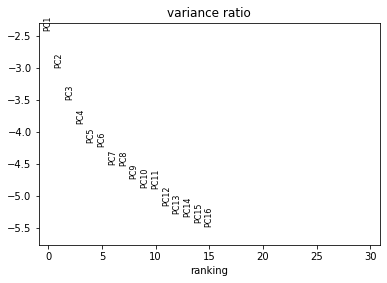

In [11]:
adata_ua.obs['n_genes_by_counts_filter'] = adata_ua.obs.n_genes_by_counts > 1000
adata_ua.obs['pct_counts_mt_filter'] = adata_ua.obs.pct_counts_mt < 20

sc.pp.log1p(adata_ua)
sc.pp.highly_variable_genes(adata_ua, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_ua_hvg = adata_ua[:, adata_ua.var['highly_variable'] == True]
adata_ua_hvg.raw = adata_ua
sc.pp.scale(adata_ua_hvg)
sc.pp.pca(adata_ua_hvg, n_comps=16)
sc.pp.neighbors(adata_ua_hvg)
sc.pl.pca_variance_ratio(adata_ua_hvg, log=True)

## Clustering
As we can see, there is no clustering info for the obs. We will have to perform clustering and add the data.
### Visualizing marker genes
At first we have to locate marker genes, so that we can later find their clusters.

__Interesting:__ _Prrx1_ gene is not among top 3000 HVGs.  

... storing 'Name' as categorical


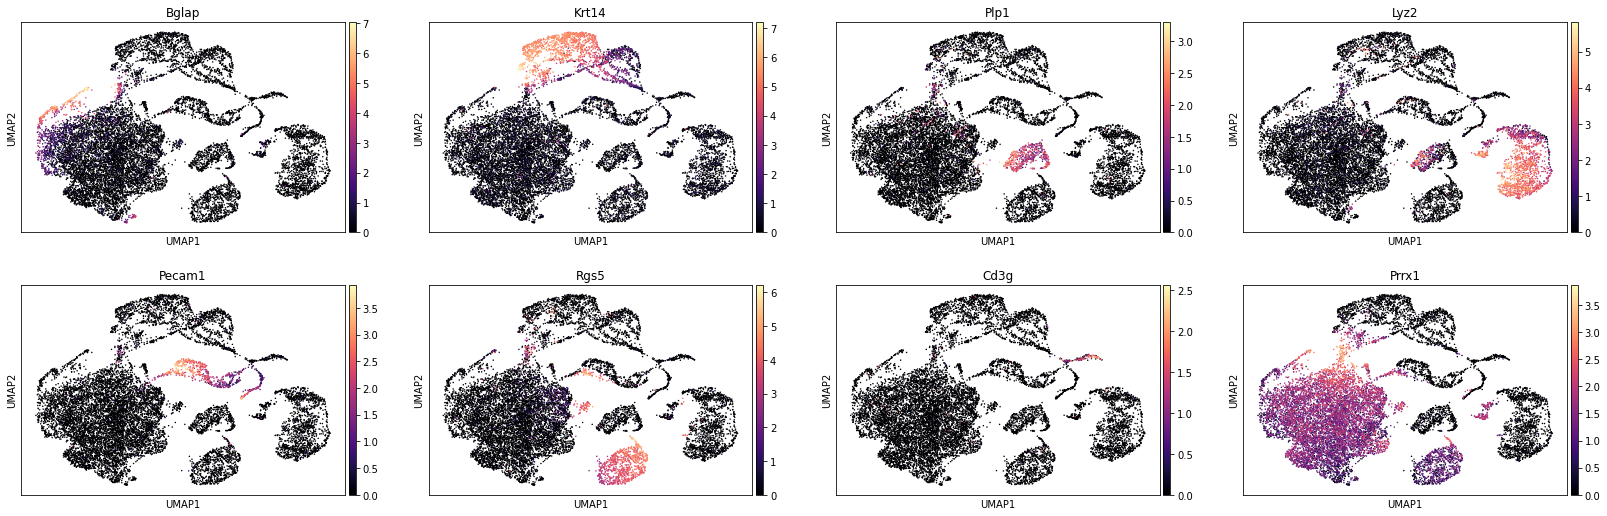

In [12]:
#visualized on adata_ua instead of adata_ua_hvg
sc.pp.pca(adata_ua, n_comps=16)
sc.pp.neighbors(adata_ua)
sc.tl.umap(adata_ua)
sc.pl.umap(adata_ua, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [13]:
# get 21 clusters (see supplements)
sc.tl.leiden(adata_ua_hvg, resolution=0.45)

# add leiden labels to the original data
adata_ua.obs['leiden'] = adata_ua_hvg.obs['leiden']

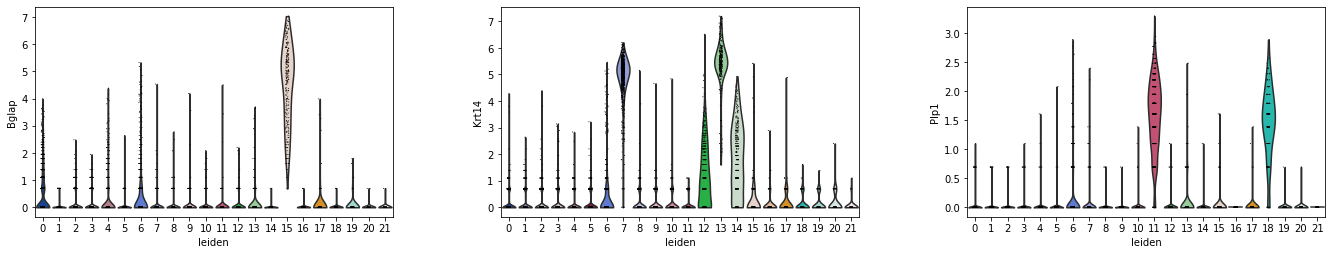

In [14]:
sc.pl.violin(adata_ua, keys=marker_genes[:3], groupby='leiden')

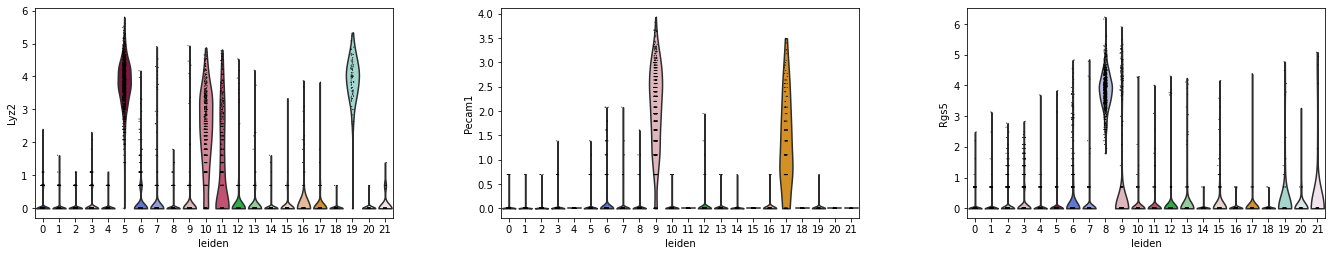

In [15]:
sc.pl.violin(adata_ua, keys=marker_genes[3:6], groupby='leiden')

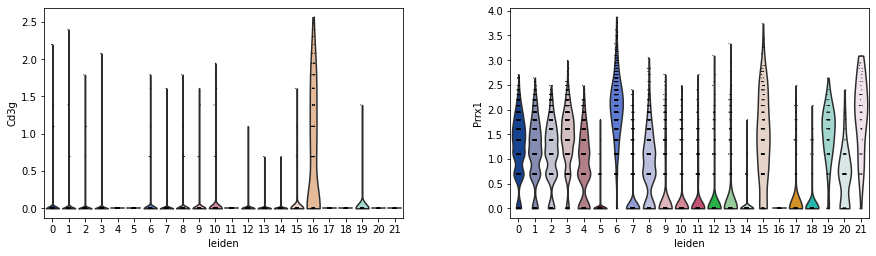

In [16]:
sc.pl.violin(adata_ua, keys=marker_genes[6:9], groupby='leiden')

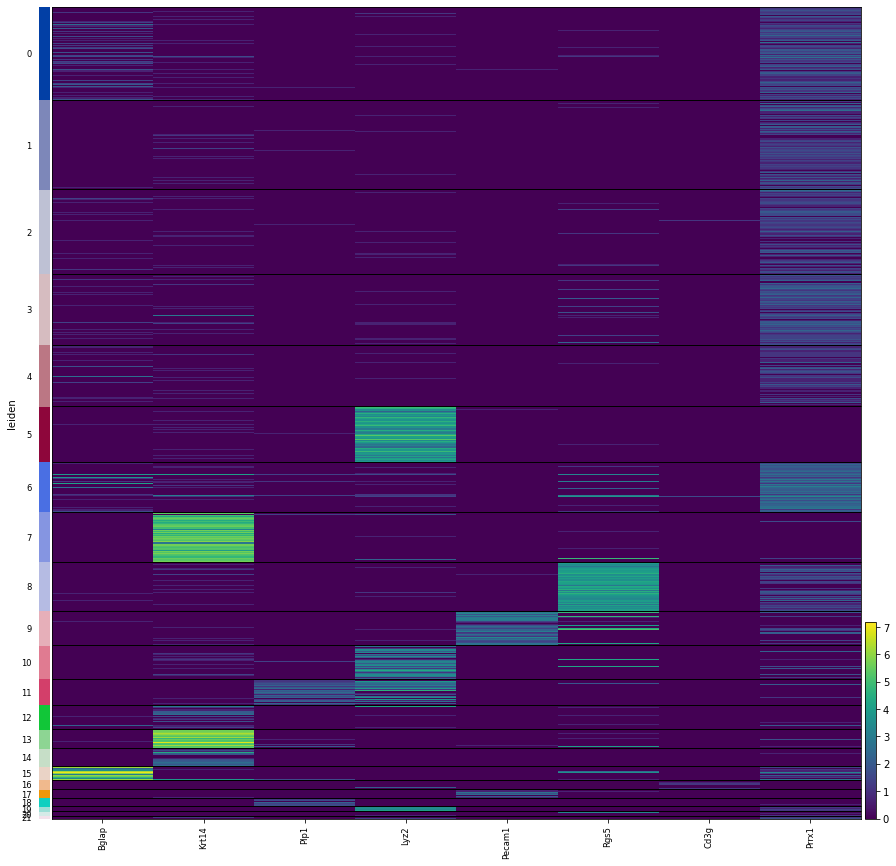

In [17]:
sc.pl.heatmap(adata_ua, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15), save='adata_ua_leiden_heatmap.png')

__add these to adata__  
__gene - cell type__  
Bglap - bone - 15  
Krt14 - epithelium - 7, 12-14  
Plp1 - Schwann cells - 11, 18  
Lyz2 - macrophages - 5, 10, 19  
Pecam1 - endothelium - 9, 17  
Rgs5 - vascular smooth muscle - 8  
Cd3g - T cells - 16  
Prrx1 - fibroblasts - 0-4, 6, 20, 21  

In [25]:
def ua_cell_type_leiden(cluster_no):
    if cluster_no == 15:
        return 'bone'
    elif cluster_no in [7, 12, 13, 14]:
        return 'epithelium'
    elif cluster_no == 18:
        return 'Schwann cell'
    elif cluster_no in [5, 10, 19]:
        return 'macrophage'
    elif cluster_no in [9, 17]:
        return 'endothelium'
    elif cluster_no == 8:
        return 'vasculars smooth muscle'
    elif cluster_no == 16:
        return 'T cell'
    elif cluster_no in [0, 1, 2, 3, 4, 6, 20, 21]:
        return 'fibroblast'

In [26]:
adata_ua.obs['type_leiden'] = adata_ua.obs['leiden'].astype(int).apply(lambda x: ua_cell_type_leiden(x))

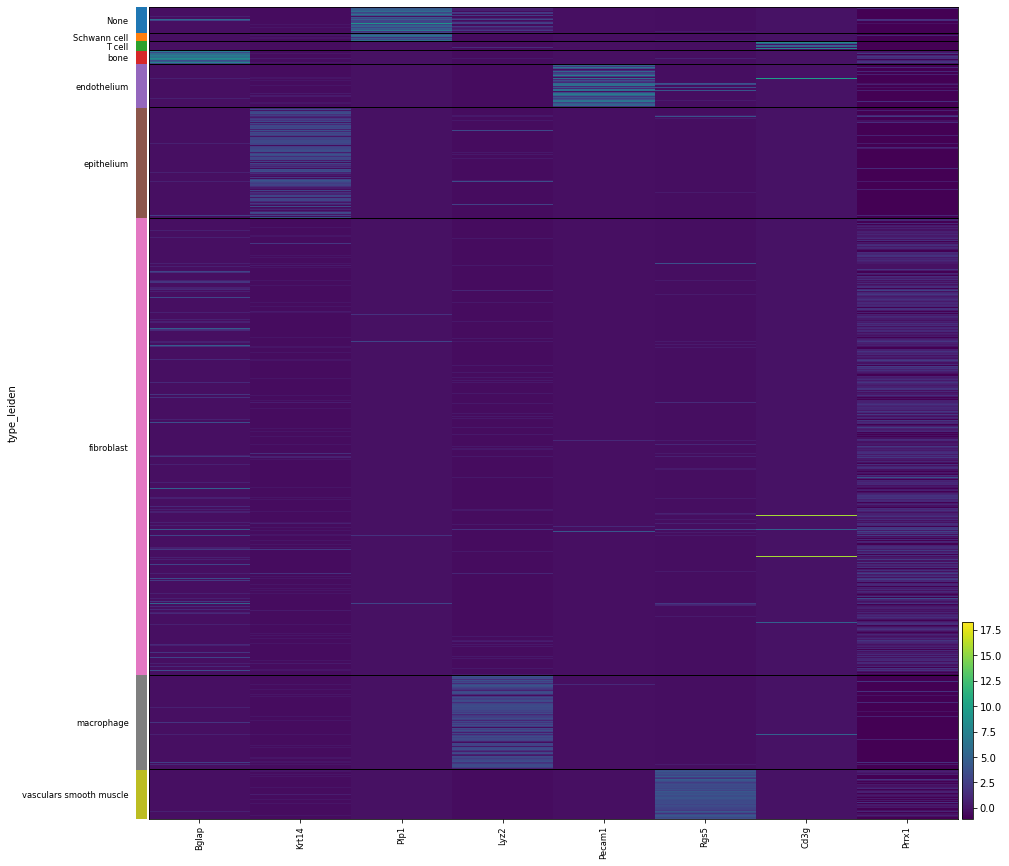

In [49]:
sc.pl.heatmap(adata_ua, gene_symbols='Name', var_names=marker_genes, groupby='type_leiden', figsize=(15,15), save='adata_ua_kmeans22_heatmap.png')

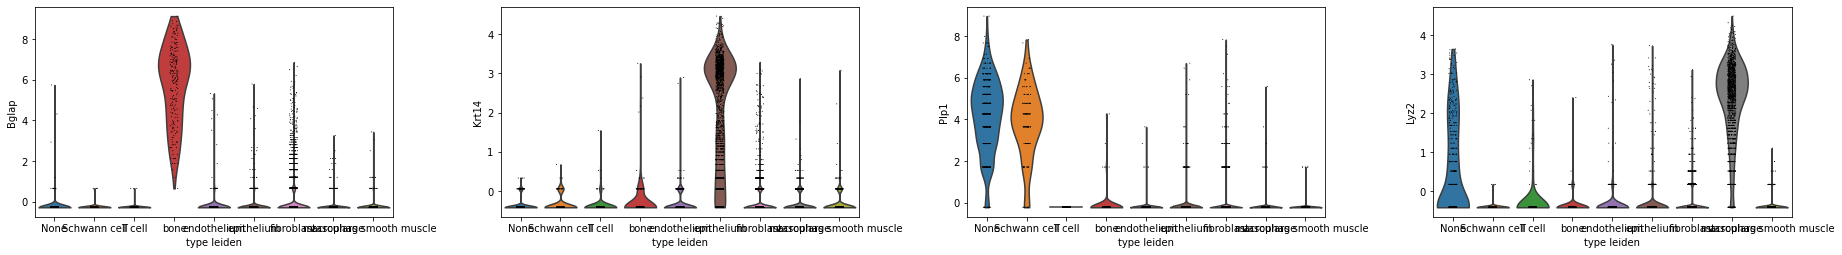

In [54]:
sc.pl.violin(adata_ua, keys=marker_genes[0:4], groupby='type_leiden')

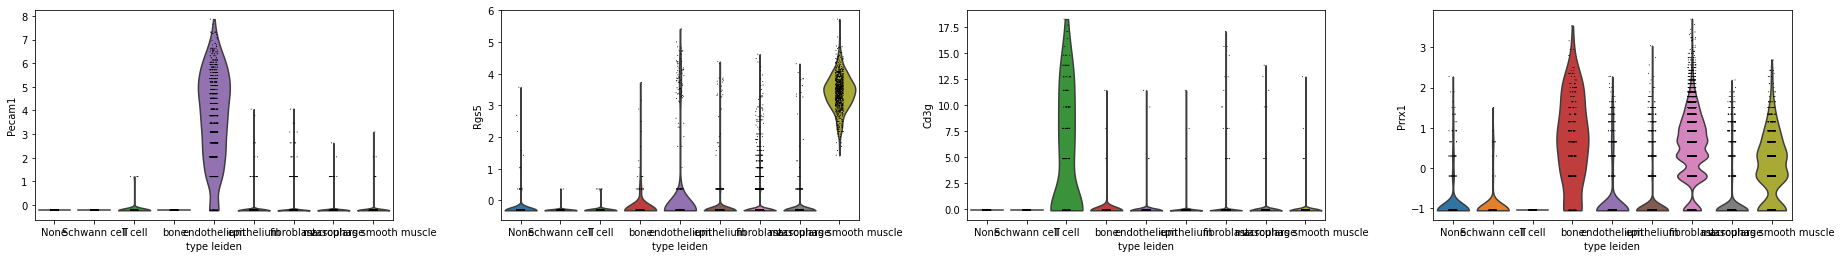

In [55]:
sc.pl.violin(adata_ua, keys=marker_genes[4:], groupby='type_leiden')

### Rank genes for characterizing groups.
Rank genes for characterizing groups using two different methods. Compare the results.

In [21]:
n_genes = 100
adata_ua.X = sc.pp.scale(adata_ua.X)

In [22]:
sc.tl.rank_genes_groups(adata_ua, groupby='type_leiden', method='logreg', n_genes=n_genes)
adata_ua_rank_genes_groups_logreg = adata_ua.uns['rank_genes_groups']

... storing 'type_leiden' as categorical
/home/jafar_isbarov/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
sc.tl.rank_genes_groups(adata_ua, groupby='type_leiden', method='t-test', n_genes=n_genes)
adata_ua_rank_genes_groups_t_test = adata_ua.uns['rank_genes_groups']

/home/jafar_isbarov/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [24]:
sc.tl.rank_genes_groups(adata_ua, groupby='type_leiden', method='wilcoxon', n_genes=n_genes)
adata_ua_rank_genes_groups_wilcoxon = adata_ua.uns['rank_genes_groups']

/home/jafar_isbarov/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


#### Compare logreg and t-test (on leiden)

In [28]:
adata_ua_rank_genes_groups_logreg_df = pd.DataFrame(adata_ua_rank_genes_groups_logreg['names'])
adata_ua_rank_genes_groups_t_test_df = pd.DataFrame(adata_ua_rank_genes_groups_t_test['names'])
adata_ua_rank_genes_groups_wilcoxon_df = pd.DataFrame(adata_ua_rank_genes_groups_wilcoxon['names'])

In [29]:
n_cell_types = len(adata_ua_rank_genes_groups_t_test_df.columns)
intersection_rate = np.zeros((n_cell_types, n_cell_types))
for i in range(n_cell_types):
    for j in range(n_cell_types):
        first_list = adata_ua_rank_genes_groups_logreg_df.iloc[:,i]
        second_list = adata_ua_rank_genes_groups_t_test_df.iloc[:,j]
        intersection = list(set(first_list) & set(second_list))
        intersection_rate[i][j] = len(intersection) / n_genes

(0.0, 9.0)

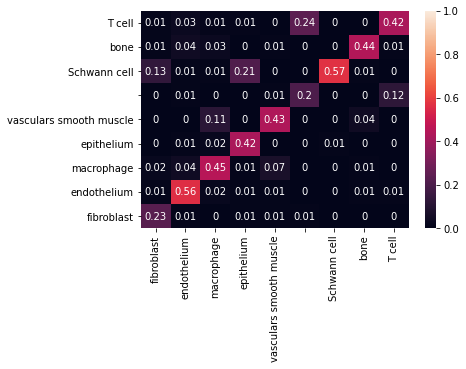

In [30]:
ua_cell_types_leiden_unique = adata_ua.obs['type_leiden'].unique()
intersection_rate = pd.DataFrame(data=intersection_rate[:,:],
                                 index=ua_cell_types_leiden_unique,
                                 columns=ua_cell_types_leiden_unique)

ax = sns.heatmap(intersection_rate, vmin = 0.0, vmax = 1.0, xticklabels=True, yticklabels=True, annot=True)
ax.invert_yaxis()
ax.set_xlim(0, n_cell_types)
ax.set_ylim(0, n_cell_types)

#### Compare WIlcoxon and t-test

In [31]:
cell_types = list(cell_types_hvgs[0]['cell type'].unique())
adata_ua_rank_genes_groups_wilcoxon_df_1 = pd.DataFrame({})
hvg = []
for cell_type in cell_types:
    hvg = list(cell_types_hvgs[0][cell_types_hvgs[0]['cell type'] == cell_type].sort_values('adj p-val', ascending=False)[:100]['gene'])
    adata_ua_rank_genes_groups_wilcoxon_df_1[cell_type] = hvg

In [32]:
adata_ua_rank_genes_groups_wilcoxon_df_1

Macrophage Vascular smooth muscle Epithelial cell Schwann cell  \
0      Fam174a                   Ech1           Lars2         Pcnp   
1         Rbm7                  Palld           Gsta4       Slc3a2   
2         Glmp                  Rbbp6             Set       Tmbim6   
3        Kdm7a                Gadd45g         Csnk1a1         Evi5   
4       Scarb2                  Rap1a          Ppp1cb      Selenot   
..         ...                    ...             ...          ...   
95     Arl6ip1          2310022B05Rik           Pdap1         Rtn3   
96        Cst3                  Actn1           Psma6        Neat1   
97  D8Ertd738e                   Klf2           Eif3h        Srp14   
98        Scp2                   Ehd1            Cct3       Rnf130   
99      Rnf130                   Fbn1          Eif1ax        Pdgfa   

               Monocyte  T cell Endothelial cell Fibroblast       Bone  
0                Hspa1b    Tspo             Rtf2      Cxcl1       Bag1  
1                Txnrd1    Lmo4           Zfand6    Tspan11   Serpinf1  
2                 Rab21    Ucp2            Med28     Tubb4b      Uqcc2  
3                 Nup98   Krit1           Arglu1       Glul      Rexo2  
4   2020-03-07 00:00:00   Actg1            Cetn3       Klf7       Rpn1  
..                  ...     ...              ...        ...        ...  
95                Trib1   Rpl32            Prkd3      Npdc1  Tnfrsf11b  
96                Rpl38  Rpl27a             Jak1      Fbln2    Arfgap3  
97                Runx3   Rps23            Psmd9     Ppp1r2      Macf1  
98                Evi2a    Rps6              Msn      Txnip     Col5a1  
99                 Plp2   Rplp2          Atp6v0b     Col5a3     Rnf121  

[100 rows x 9 columns]

In [33]:
n_cell_types = len(adata_ua_rank_genes_groups_t_test_df.columns)
intersection_rate = np.zeros((n_cell_types, n_cell_types))
for i in range(n_cell_types):
    for j in range(n_cell_types):
        first_list = adata_ua_rank_genes_groups_wilcoxon_df.iloc[:,i]
        second_list = adata_ua_rank_genes_groups_t_test_df.iloc[:,j]
        intersection = list(set(first_list) & set(second_list))
        intersection_rate[i][j] = len(intersection) / n_genes

(0.0, 9.0)

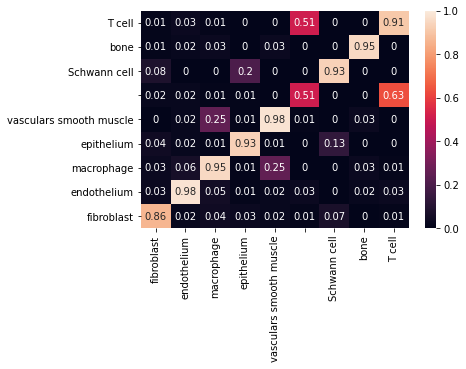

In [34]:
ua_cell_types_leiden_unique = adata_ua.obs['type_leiden'].unique()
intersection_rate = pd.DataFrame(data=intersection_rate[:,:],
                                 index=ua_cell_types_leiden_unique,
                                 columns=ua_cell_types_leiden_unique)

ax = sns.heatmap(intersection_rate, vmin = 0.0, vmax = 1.0, xticklabels=True, yticklabels=True, annot=True)
ax.invert_yaxis()
ax.set_xlim(0, n_cell_types)
ax.set_ylim(0, n_cell_types)

#### Compare (my) Wilcoxon and logreg

(0.0, 9.0)

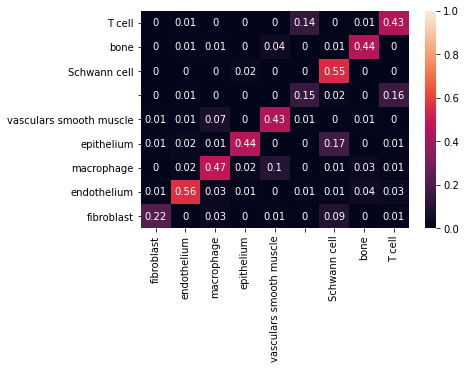

In [35]:
n_cell_types = len(adata_ua_rank_genes_groups_t_test_df.columns)
intersection_rate = np.zeros((n_cell_types, n_cell_types))
for i in range(n_cell_types):
    for j in range(n_cell_types):
        first_list = adata_ua_rank_genes_groups_wilcoxon_df.iloc[:,i]
        second_list = adata_ua_rank_genes_groups_logreg_df.iloc[:,j]
        intersection = list(set(first_list) & set(second_list))
        intersection_rate[i][j] = len(intersection) / n_genes
        
ua_cell_types_leiden_unique = adata_ua.obs['type_leiden'].unique()
intersection_rate = pd.DataFrame(data=intersection_rate[:,:],
                                 index=ua_cell_types_leiden_unique,
                                 columns=ua_cell_types_leiden_unique)

ax = sns.heatmap(intersection_rate, vmin = 0.0, vmax = 1.0, xticklabels=True, yticklabels=True, annot=True)
ax.invert_yaxis()
ax.set_xlim(0, n_cell_types)
ax.set_ylim(0, n_cell_types)      

#### Compare Wilcoxon and logreg

In [36]:
n_cell_types = len(adata_ua_rank_genes_groups_t_test_df.columns)
intersection_rate = np.zeros((n_cell_types, n_cell_types))
for i in range(n_cell_types):
    for j in range(n_cell_types):
        first_list = adata_ua_rank_genes_groups_wilcoxon_df.iloc[:,i]
        second_list = adata_ua_rank_genes_groups_logreg_df.iloc[:,j]
        intersection = list(set(first_list) & set(second_list))
        intersection_rate[i][j] = len(intersection) / n_genes

(0.0, 9.0)

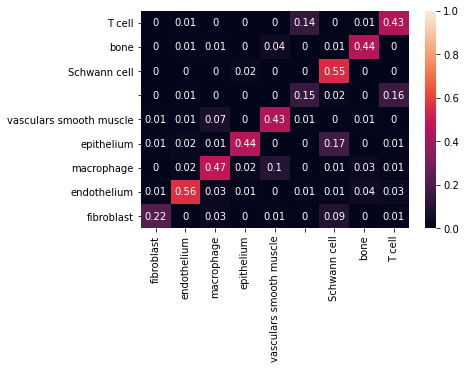

In [37]:
ua_cell_types_leiden_unique = adata_ua.obs['type_leiden'].unique()
intersection_rate = pd.DataFrame(data=intersection_rate[:,:],
                                 index=ua_cell_types_leiden_unique,
                                 columns=ua_cell_types_leiden_unique)

ax = sns.heatmap(intersection_rate, vmin = 0.0, vmax = 1.0, xticklabels=True, yticklabels=True, annot=True)
ax.invert_yaxis()
ax.set_xlim(0, n_cell_types)
ax.set_ylim(0, n_cell_types)

### K-means clustering

Since our `adata.X` is a sparse matrix, we have to use `sklearn.decomposition.TruncatedSVD` instead of `sklearn.decomposition.PCA`.

In [38]:
def explained_variance_ratio(adata):
    tSVD = TruncatedSVD(n_components=100).fit(adata.X)
    plt.plot(np.cumsum(tSVD.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.xlim(0,100)
    plt.show()

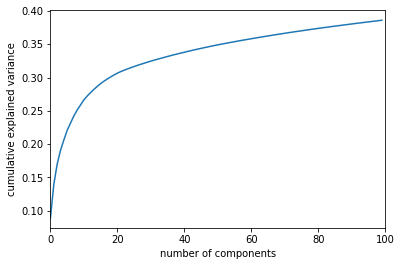

In [39]:
explained_variance_ratio(adata_ua_hvg)

30 is roughly the point of diminishing returns, so we will accept it as the number of components.

In [40]:
reduced_data_ua_hvg = TruncatedSVD(n_components=30).fit_transform(adata_ua_hvg.X)

I will initially use `n_clusters=22`, as this was the number of clusters gained in the paper.

In [41]:
kmeans = KMeans(n_clusters=22, random_state=0).fit(reduced_data_ua_hvg) 
adata_ua.obs['kmeans22'] = kmeans.labels_.astype(str)

... storing 'type_leiden' as categorical
... storing 'kmeans22' as categorical


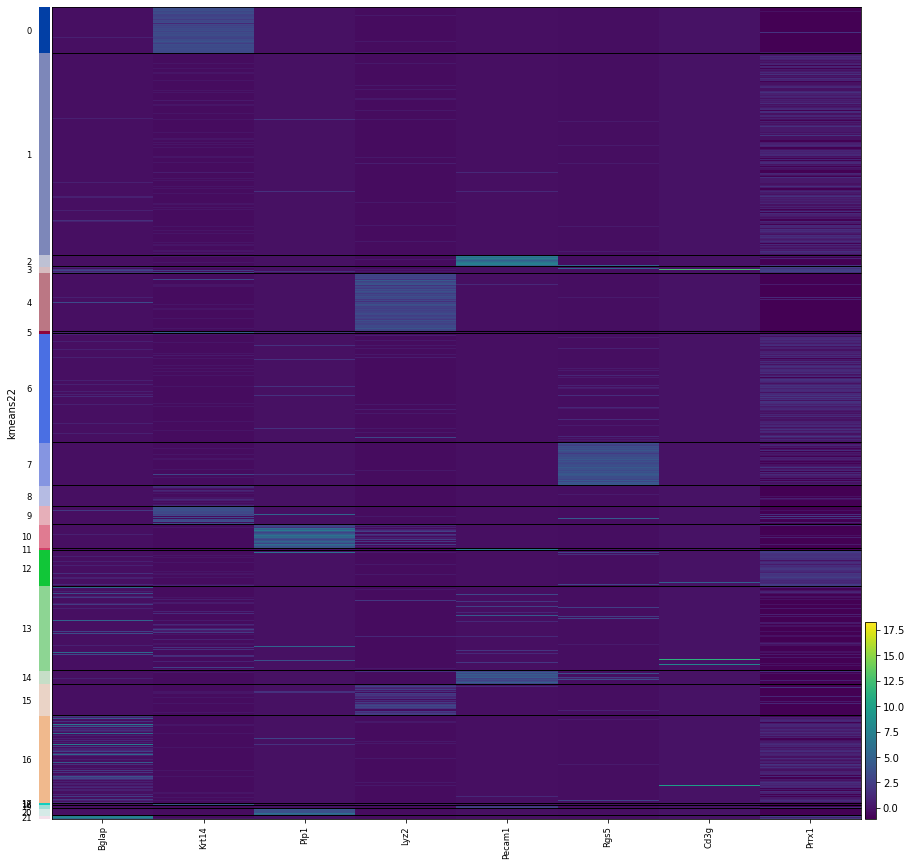

In [42]:
sc.pl.heatmap(adata_ua, gene_symbols='Name', var_names=marker_genes, groupby='kmeans22', figsize=(15,15), save='adata_ua_kmeans22_heatmap.png')

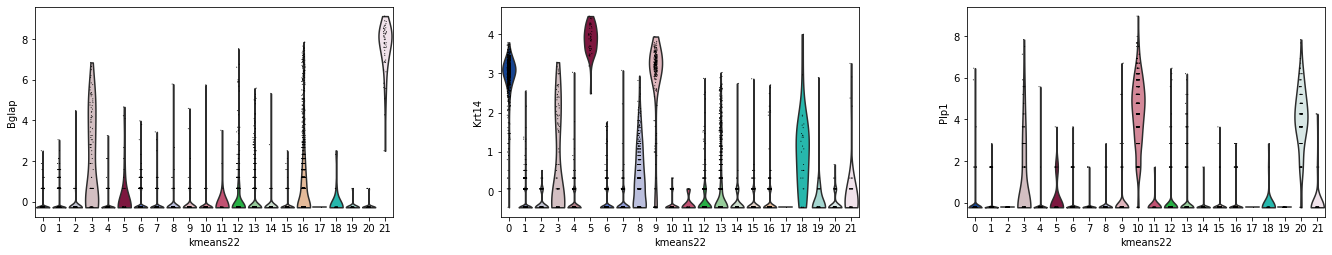

In [60]:
sc.pl.violin(adata_ua, keys=marker_genes[:3], groupby='kmeans22')

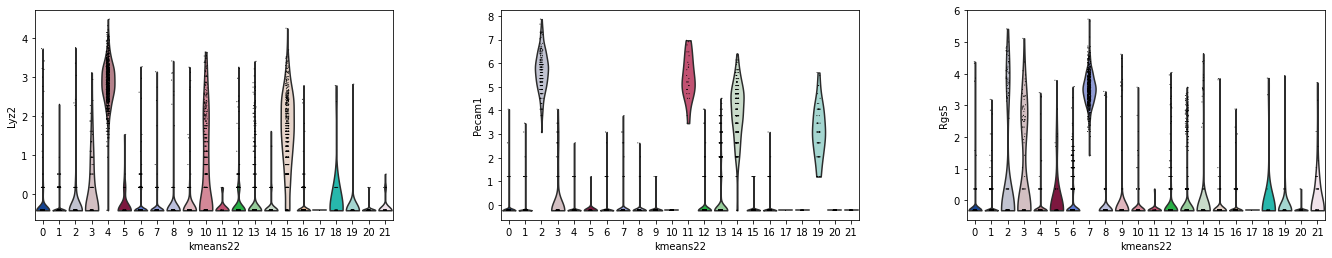

In [61]:
sc.pl.violin(adata_ua, keys=marker_genes[3:6], groupby='kmeans22')

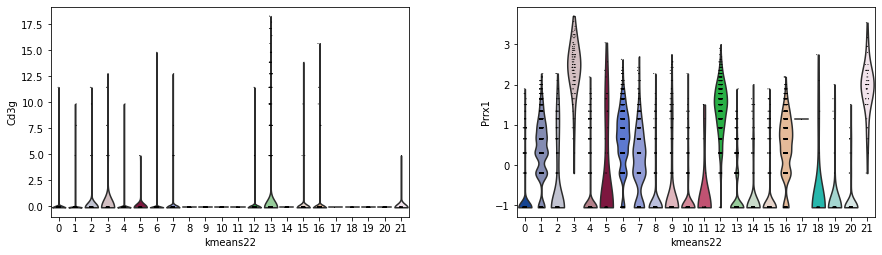

In [59]:
sc.pl.violin(adata_ua, keys=marker_genes[6:], groupby='kmeans22')

__gene - cell type - cluster(s)__  
Bglap - bone - 21  
Krt14 - epithelium - 0, 3, 5, 8, 9, 18   
Plp1 - Schwann cells - 10, 20    
Lyz2 - macrophages - 4, 15    
Pecam1 - endothelium - 2, 11, 14, 19  
Rgs5 - vascular smooth muscle - 7  
Cd3g - T cells - 13  
Prrx1 - fibroblasts - 1, 3, 6, 12, 16, 21  

In [62]:
def ua_cell_type_kmeans(cluster_no):
    if cluster_no in [21]:
        return 'bone'
    elif cluster_no in [0, 3, 5, 8, 9, 18]:
        return 'epithelium'
    elif cluster_no in [10, 20]:
        return 'Schwann cell'
    elif cluster_no in [4, 15]:
        return 'macrophage'
    elif cluster_no in [2, 11, 14, 19]:
        return 'endothelium'
    elif cluster_no == 13:
        return 'vasculars smooth muscle'
    elif cluster_no in [1, 3, 6, 12, 16, 21]:
        return 'fibroblast'
    else:
        return 'T cell'

In [63]:
adata_ua.obs['type_kmeans'] = adata_ua.obs['kmeans22'].astype(int).apply(lambda x: ua_cell_type_leiden(x))

... storing 'type_kmeans' as categorical


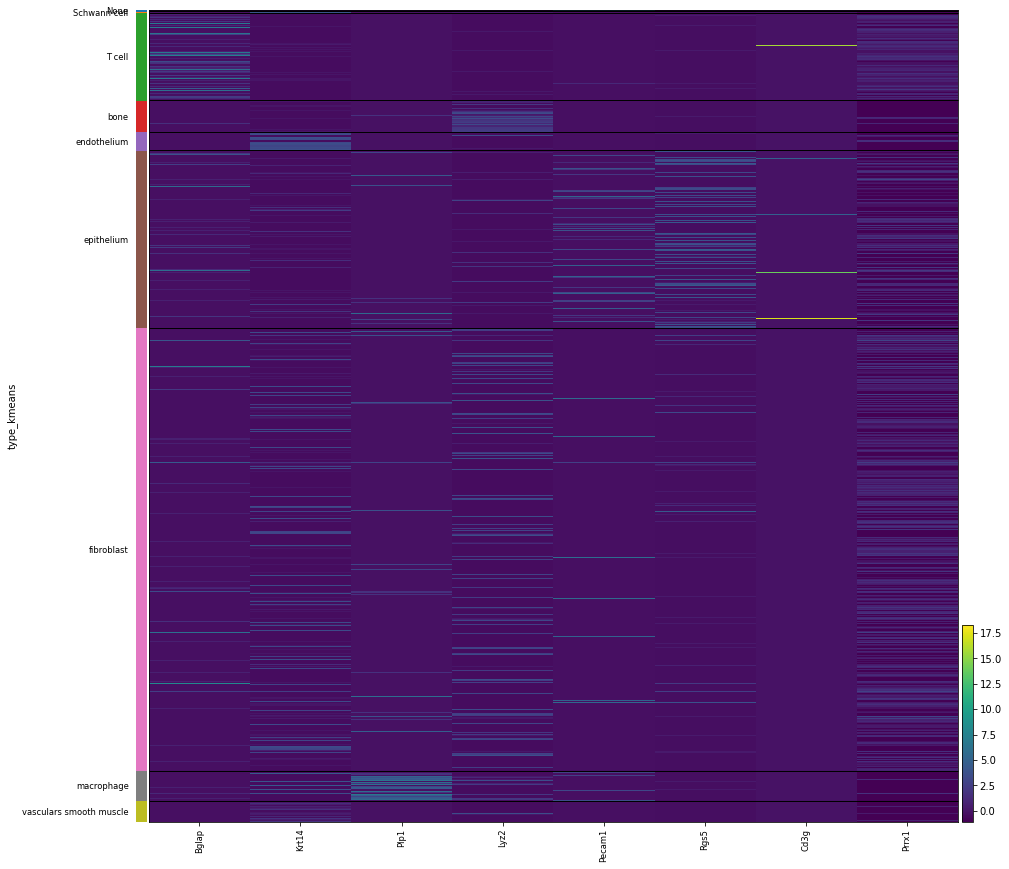

In [64]:
sc.pl.heatmap(adata_ua, gene_symbols='Name', var_names=marker_genes, groupby='type_kmeans', figsize=(15,15), save='adata_ua_kmeans22_heatmap.png')

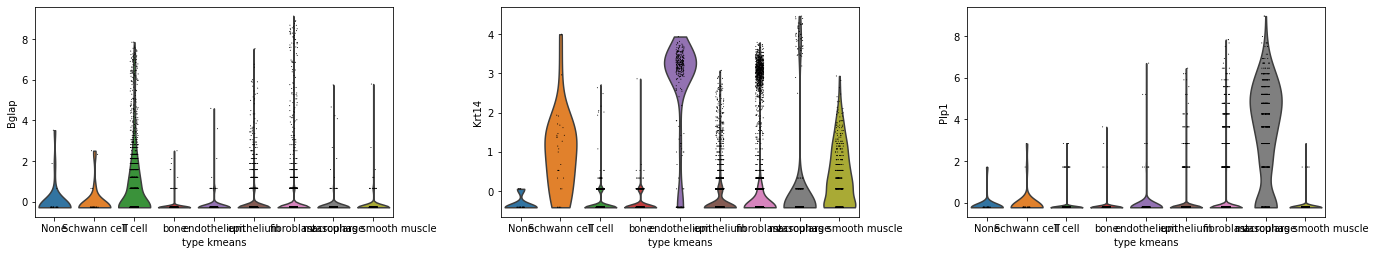

In [65]:
sc.pl.violin(adata_ua, keys=marker_genes[:3], groupby='type_kmeans')

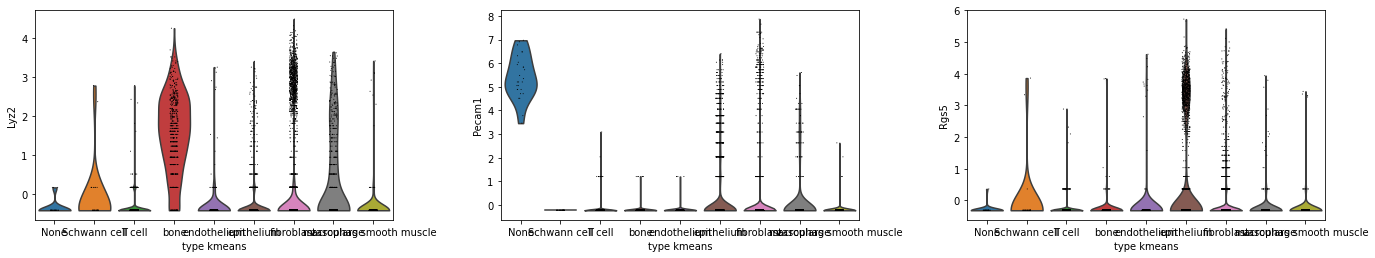

In [66]:
sc.pl.violin(adata_ua, keys=marker_genes[3:6], groupby='type_kmeans')

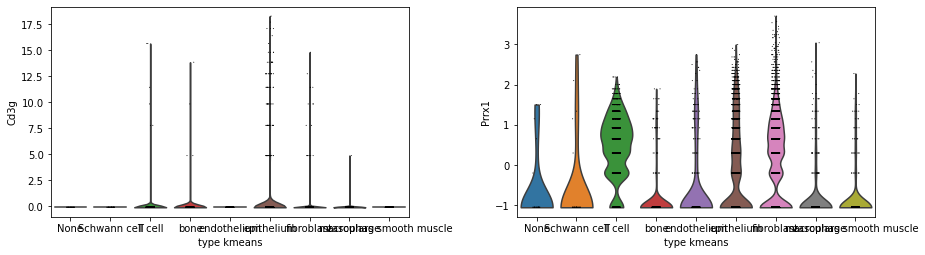

In [67]:
sc.pl.violin(adata_ua, keys=marker_genes[6:], groupby='type_kmeans')

### Comparison of KMeans and Leiden clusterings

In [69]:
ARI_leiden_kmeans = adjusted_rand_score(adata_ua.obs['leiden'], adata_ua.obs['kmeans22'])
jaccard_leiden_kmeans = jaccard_score(adata_ua.obs['leiden'], adata_ua.obs['kmeans22'], average='weighted')
AMI_leiden_kmeans = adjusted_mutual_info_score(adata_ua.obs['leiden'], adata_ua.obs['kmeans22'])
silhouette_leiden = silhouette_score(adata_ua.X, adata_ua.obs['leiden'])
silhouette_kmeans = silhouette_score(adata_ua.X, adata_ua.obs['kmeans22'])
CHS_leiden = calinski_harabasz_score(adata_ua.X, adata_ua.obs['leiden'])
CHS_kmeans = calinski_harabasz_score(adata_ua.X, adata_ua.obs['kmeans22'])

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_leiden_kmeans)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_leiden_kmeans)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_leiden_kmeans)
print('Silhouette Coefficient (leiden):          ', '[-1,1]    ', silhouette_leiden)
print('Silhouette Coefficient (kmeans):          ', '[-1,1]    ', silhouette_kmeans)
print('Calinski-Harabasz Index (leiden):   ', '[-,-]     ', CHS_leiden)
print('Calinski-Harabasz Index (kmeans):         ', '[-,-]     ', CHS_leiden)
print('--------------------------------------------------------')

--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.49828085510331993
Jaccard Index:                    [0,1]      0.05077737221881338
Adjusted Mutual Information:      [0,1]      0.730624260390535
Silhouette Coefficient (leiden):           [-1,1]     -0.12233603
Silhouette Coefficient (kmeans):           [-1,1]     -0.079225674
Calinski-Harabasz Index (leiden):    [-,-]      51.28582495674849
Calinski-Harabasz Index (kmeans):          [-,-]      51.28582495674849
--------------------------------------------------------


### Intersection size of leiden and kmeans clusters

In [70]:
# TODO: improve the algorithm
def intersection_size(col_1, col_2):
    '''returns perctage of col_2 that intersects with the col_1'''
    total = 0
    for item_2 in col_2:
        for item_1 in col_1:
            if item_2 == item_1:
                total += 1
                break
                
    return total/len(col_1)

In [71]:
cluster_numbers = sorted(adata_ua.obs['leiden'].unique().map(int))
cluster_numbers = map(str, cluster_numbers)
adata_leiden = pd.DataFrame([])
for cluster in cluster_numbers:
    cluster_col = adata_ua.obs[adata_ua.obs['leiden'] == cluster]
    cluster_col = pd.DataFrame({f'{cluster}': cluster_col.index})
    adata_leiden = pd.concat([adata_leiden, cluster_col], axis=1)
    
cluster_numbers = sorted(adata_ua.obs['kmeans22'].unique().map(int))
cluster_numbers = map(str, cluster_numbers)
adata_kmeans = pd.DataFrame([])
for cluster in cluster_numbers:
    cluster_col = adata_ua.obs[adata_ua.obs['kmeans22'] == cluster]
    cluster_col = pd.DataFrame({f'{cluster}': cluster_col.index})
    adata_kmeans = pd.concat([adata_kmeans, cluster_col], axis=1)

In [72]:
int_size = np.zeros((len(adata_leiden.columns), len(adata_kmeans.columns)))
for i in range(len(adata_leiden.columns)):
    for j in range(len(adata_kmeans.columns)):
        leiden_col = adata_leiden.iloc[:,i].dropna()
        kmeans_col = adata_kmeans.iloc[:,j].dropna()
        int_size[i][j] = intersection_size(leiden_col, kmeans_col)

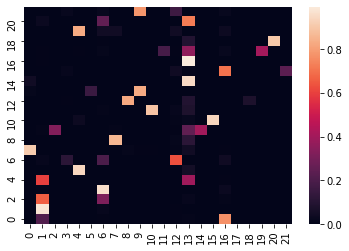

In [73]:
ax = sns.heatmap(int_size)
ax.invert_yaxis()

# 11dpa
## Pre-processing

In [75]:
adata_11dpa = adatas[1].copy()
adata_ua.var_names = adata_ua.var['Name']
adata_11dpa.var_names_make_unique()

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_11dpa.X = adata_11dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_11dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_11dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_11dpa.var['mt'] = adata_11dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_11dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Text(0.5, 1.0, 'percentage of mitochondrial counts')

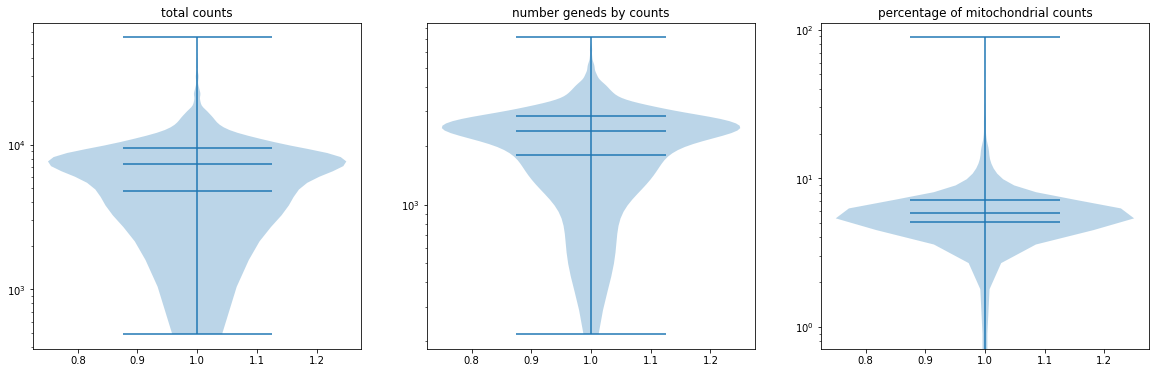

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axs[0].violinplot(adata_11dpa.obs['total_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[0].set_yscale('log')
axs[0].set_title('total counts')
axs[1].violinplot(adata_11dpa.obs['n_genes_by_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[1].set_yscale('log')
axs[1].set_title('number geneds by counts')
axs[2].violinplot(adata_11dpa.obs['pct_counts_mt'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[2].set_yscale('log')
axs[2].set_title('percentage of mitochondrial counts')

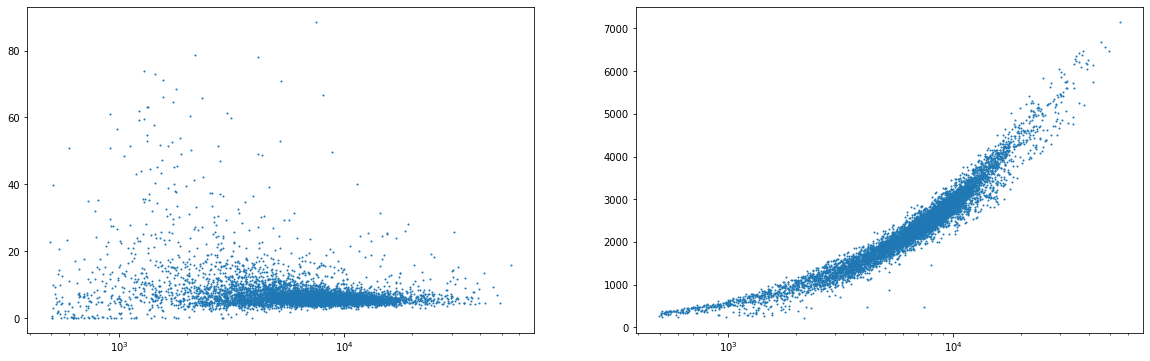

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axs[0].scatter(x=adata_11dpa.obs['total_counts'], y = adata_11dpa.obs['pct_counts_mt'], s=1)
axs[0].set_xscale('log')
axs[1].scatter(x=adata_11dpa.obs['total_counts'], y = adata_11dpa.obs['n_genes_by_counts'], s=1)
axs[1].set_xscale('log')

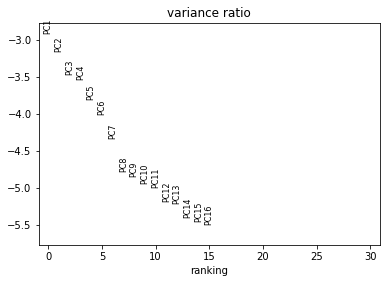

In [78]:
adata_11dpa.obs['n_genes_by_counts_filter'] = adata_11dpa.obs.n_genes_by_counts > 1500
adata_11dpa.obs['pct_counts_mt_filter'] = adata_11dpa.obs.pct_counts_mt < 20

sc.pp.log1p(adata_11dpa)
sc.pp.highly_variable_genes(adata_11dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_11dpa_hvg = adata_11dpa[:, adata_11dpa.var['highly_variable'] == True]
adata_11dpa_hvg.raw = adata_11dpa
sc.pp.scale(adata_11dpa_hvg)
sc.pp.pca(adata_11dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_11dpa_hvg)
sc.pl.pca_variance_ratio(adata_11dpa_hvg, log=True)

## Clustering
### Visualizing marker genes

... storing 'Name' as categorical


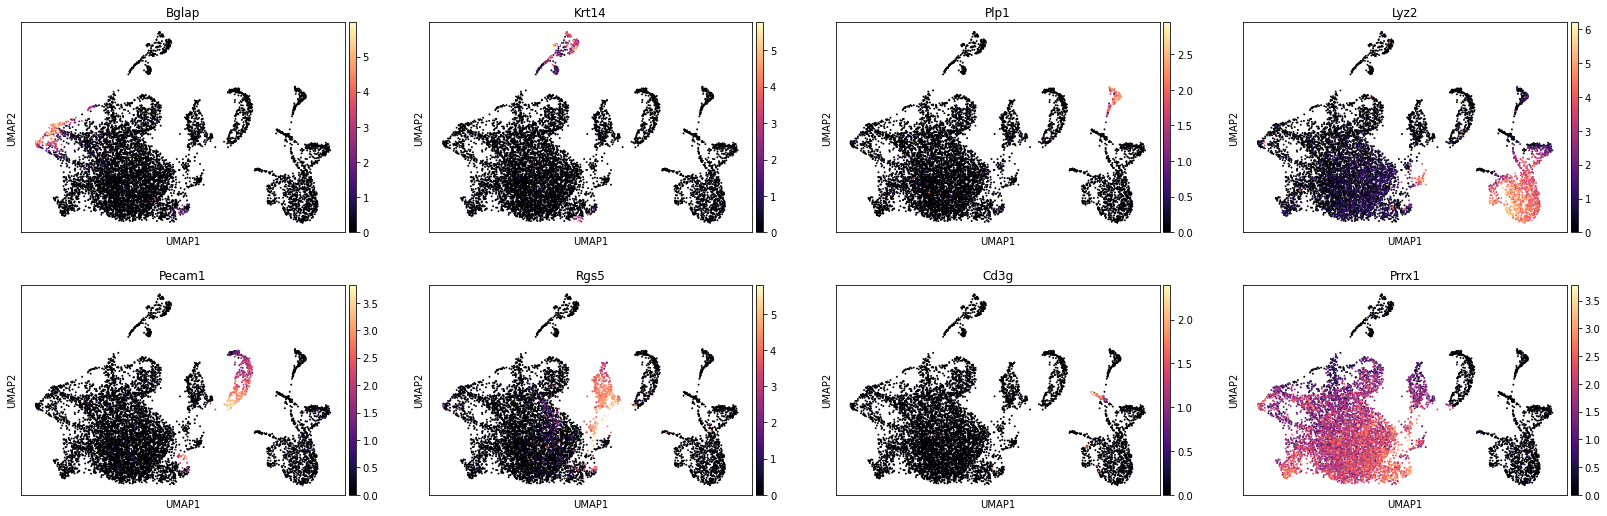

In [79]:
sc.pp.pca(adata_11dpa)
sc.pp.neighbors(adata_11dpa)
sc.tl.umap(adata_11dpa)
sc.pl.umap(adata_11dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [80]:
sc.tl.leiden(adata_11dpa_hvg, resolution=0.6)
adata_11dpa.obs['leiden'] = adata_11dpa_hvg.obs['leiden']

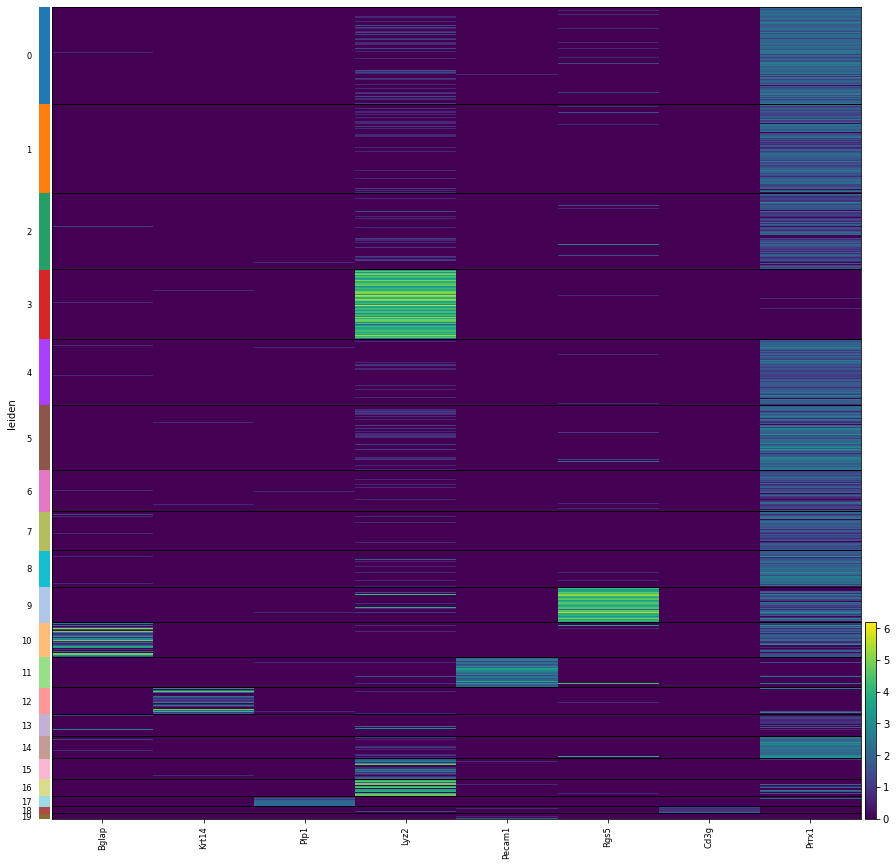

In [81]:
sc.pl.heatmap(adata_11dpa, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15))

__gene - cell type__  
Bglap - bone - 10  
Krt14 - epithelium - 12  
Plp1 - Schwann cells - 17  
Lyz2 - macrophages - 3, 15, 16  
Pecam1 - endothelium - 11, 19  
Rgs5 - vascular smooth muscle - 9  
Cd3g - T cells - 18  
Prrx1 - fibroblasts - 0-2, 4-8, 13, 14   

### K-means clustering

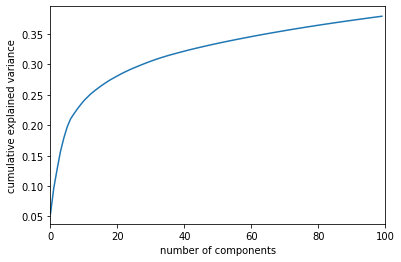

In [82]:
explained_variance_ratio(adata_11dpa_hvg)

30 can be said to be the point of diminishing returns, so take 30 components.

In [83]:
reduced_data_11dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_11dpa_hvg.X)

Kmeans:  
Bglap - #6  
Krt14 - #7  
Plp1 - #2  
Lyz2 - #1 #2 #4 #11 #15  
Pecam1 - #5  
Rgs5 - #12  
Cd3g - #10  
Prrx1 - #3 #6 #8 #9 #12 #13 #14 #16

In [84]:
kmeans = KMeans(n_clusters=17, random_state=0).fit(reduced_data_11dpa_hvg) 
adata_11dpa.obs['kmeans17'] = kmeans.labels_.astype(str)

... storing 'kmeans17' as categorical


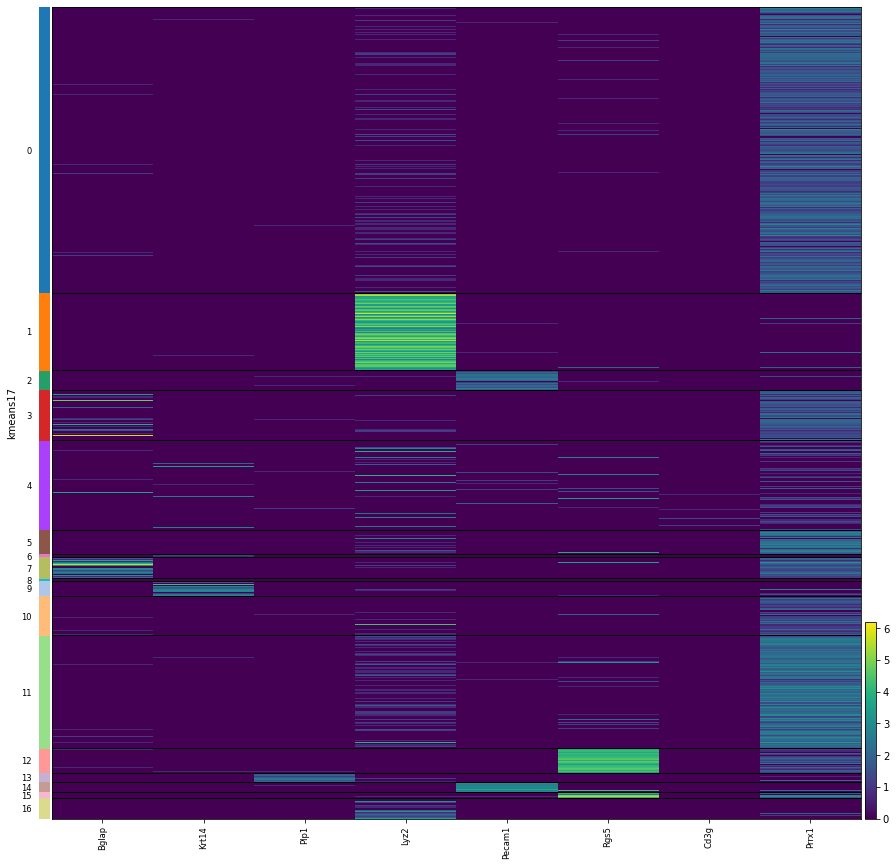

In [85]:
sc.pl.heatmap(adata_11dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans17', figsize=(15,15))

__gene - cell type__  
Bglap - bone  
Krt14 - epithelium  
Plp1 - Schwann cells  
Lyz2 - macrophages  
Pecam1 - endothelium  
Rgs5 - vascular smooth muscle  
Cd3g - T cells  
Prrx1 - fibroblasts  

### Comparison of Leiden and KMeans clusterings

In [89]:
ARI_leiden_kmeans = adjusted_rand_score(adata_11dpa.obs['leiden'], adata_11dpa.obs['kmeans17'])
jaccard_leiden_kmeans = jaccard_score(adata_11dpa.obs['leiden'], adata_11dpa.obs['kmeans17'], average='weighted')
AMI_leiden_kmeans = adjusted_mutual_info_score(adata_11dpa.obs['leiden'], adata_11dpa.obs['kmeans17'])
silhouette_leiden = silhouette_score(adata_11dpa.X, adata_11dpa.obs['leiden'])
silhouette_kmeans = silhouette_score(adata_11dpa.X, adata_11dpa.obs['kmeans17'])
CHS_leiden = calinski_harabasz_score(adata_11dpa.X.toarray(), adata_11dpa.obs['leiden'])
CHS_kmeans = calinski_harabasz_score(adata_11dpa.X.toarray(), adata_11dpa.obs['kmeans17'])

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_leiden_kmeans)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_leiden_kmeans)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_leiden_kmeans)
print('Silhouette Coefficient (leiden):          ', '[-1,1]    ', silhouette_leiden)
print('Silhouette Coefficient (kmeans):          ', '[-1,1]    ', silhouette_kmeans)
print('Calinski-Harabasz Index (leiden):   ', '[-,-]     ', CHS_leiden)
print('Calinski-Harabasz Index (kmeans):         ', '[-,-]     ', CHS_leiden)
print('--------------------------------------------------------')

--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.3165823679257621
Jaccard Index:                    [0,1]      0.01702403221887781
Adjusted Mutual Information:      [0,1]      0.6389970086504809
Silhouette Coefficient (leiden):           [-1,1]     -0.03288893
Silhouette Coefficient (kmeans):           [-1,1]     0.015600156
Calinski-Harabasz Index (leiden):    [-,-]      112.46811105708441
Calinski-Harabasz Index (kmeans):          [-,-]      112.46811105708441
--------------------------------------------------------


# 12dpa

In [90]:
adata_12dpa = adatas[2].copy()
adata_ua.var_names = adata_ua.var['Name']
adata_12dpa.var_names_make_unique()

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_12dpa.X = adata_12dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_12dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_12dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_12dpa.var['mt'] = adata_12dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_12dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Text(0.5, 1.0, 'percentage of mitochondrial counts')

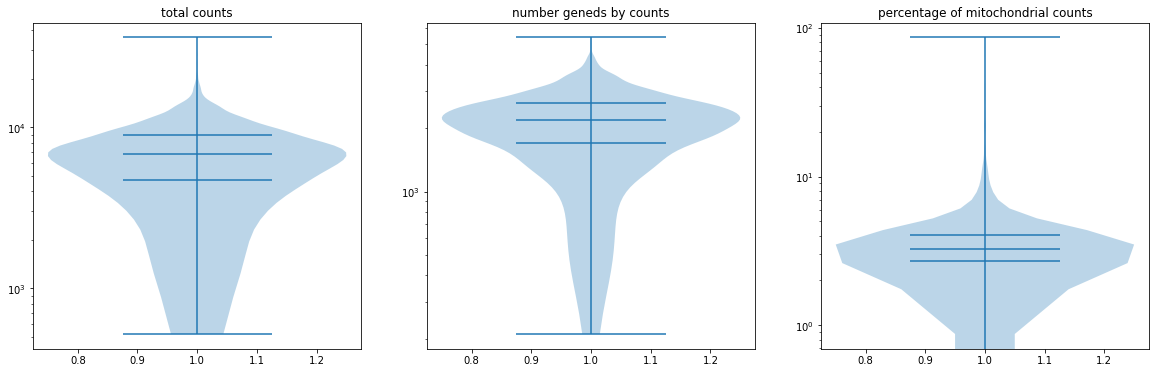

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axs[0].violinplot(adata_12dpa.obs['total_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[0].set_yscale('log')
axs[0].set_title('total counts')
axs[1].violinplot(adata_12dpa.obs['n_genes_by_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[1].set_yscale('log')
axs[1].set_title('number geneds by counts')
axs[2].violinplot(adata_12dpa.obs['pct_counts_mt'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[2].set_yscale('log')
axs[2].set_title('percentage of mitochondrial counts')

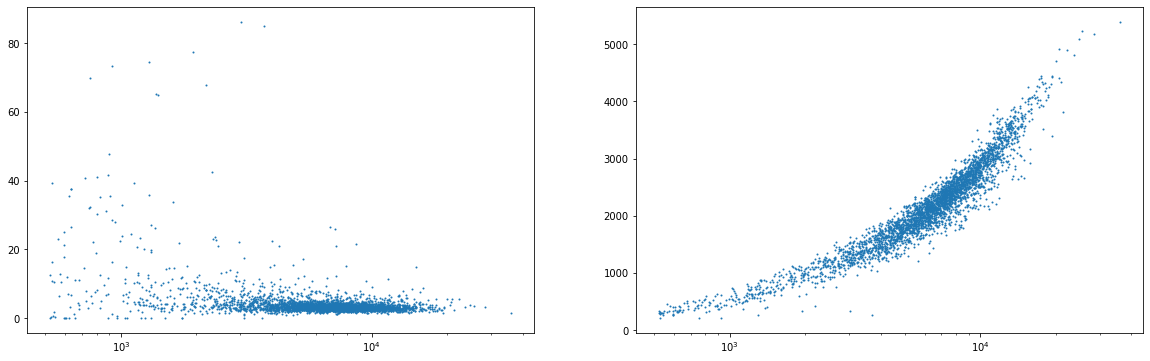

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axs[0].scatter(x=adata_12dpa.obs['total_counts'], y = adata_12dpa.obs['pct_counts_mt'], s=1)
axs[0].set_xscale('log')
axs[1].scatter(x=adata_12dpa.obs['total_counts'], y = adata_12dpa.obs['n_genes_by_counts'], s=1)
axs[1].set_xscale('log')

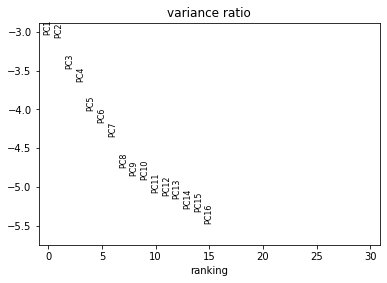

In [93]:
adata_12dpa.obs['n_genes_by_counts_filter'] = adata_12dpa.obs.n_genes_by_counts > 1500
adata_12dpa.obs['pct_counts_mt_filter'] = adata_12dpa.obs.pct_counts_mt < 15

sc.pp.log1p(adata_12dpa)
sc.pp.highly_variable_genes(adata_12dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_12dpa_hvg = adata_12dpa[:, adata_12dpa.var['highly_variable'] == True]
adata_12dpa_hvg.raw = adata_12dpa
sc.pp.scale(adata_12dpa_hvg)
sc.pp.pca(adata_12dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_12dpa_hvg)
sc.pl.pca_variance_ratio(adata_12dpa_hvg, log=True)

## Clustering¶
### Visualizing marker genes

... storing 'Name' as categorical


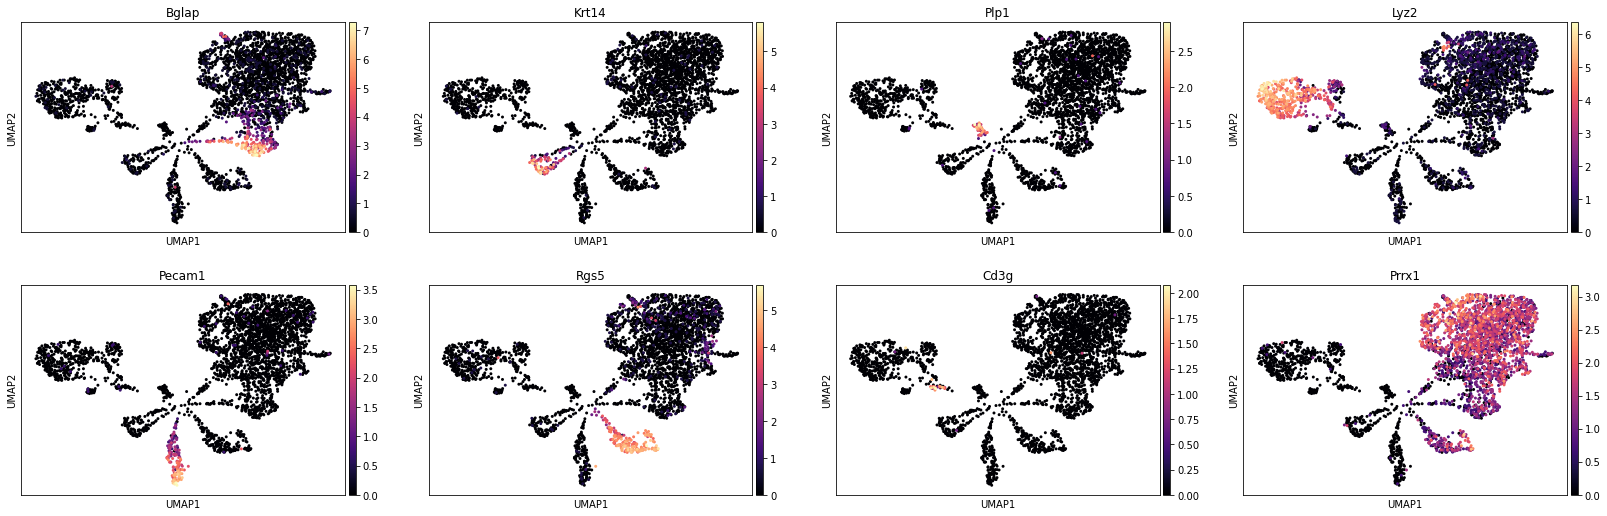

In [94]:
sc.pp.pca(adata_12dpa)
sc.pp.neighbors(adata_12dpa)
sc.tl.umap(adata_12dpa)
sc.pl.umap(adata_12dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [95]:
sc.tl.leiden(adata_12dpa_hvg, resolution=0.6)
adata_12dpa.obs['leiden'] = adata_12dpa_hvg.obs['leiden']

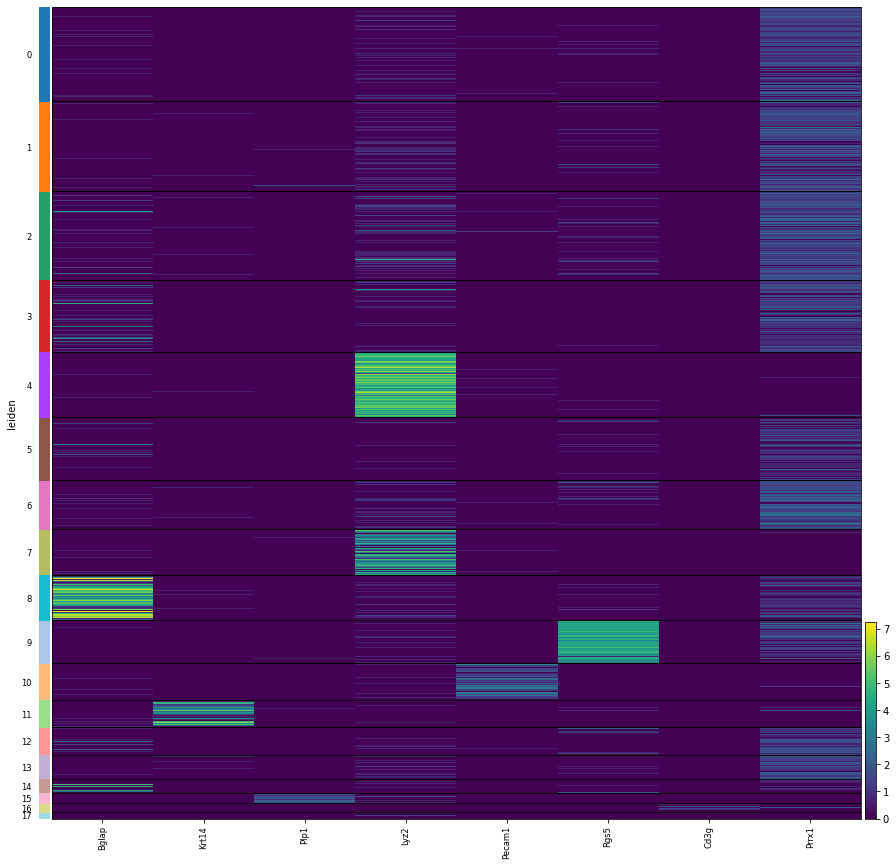

In [96]:
sc.pl.heatmap(adata_12dpa, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15))

__gene - cell type__  
Bglap - bone  
Krt14 - epithelium  
Plp1 - Schwann cells  
Lyz2 - macrophages  
Pecam1 - endothelium  
Rgs5 - vascular smooth muscle  
Cd3g - T cells  
Prrx1 - fibroblasts  

### K-means clustering

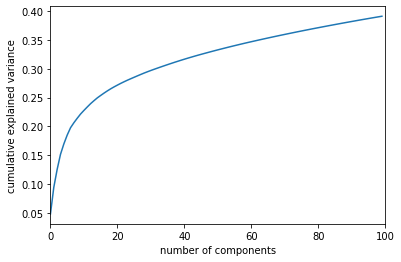

In [97]:
explained_variance_ratio(adata_12dpa_hvg)

30 can be said to be the point of diminishing returns.

In [98]:
reduced_data_12dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_12dpa_hvg.X)

In [99]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(reduced_data_12dpa_hvg) 
adata_12dpa.obs['kmeans15'] = kmeans.labels_.astype(str)

... storing 'kmeans15' as categorical


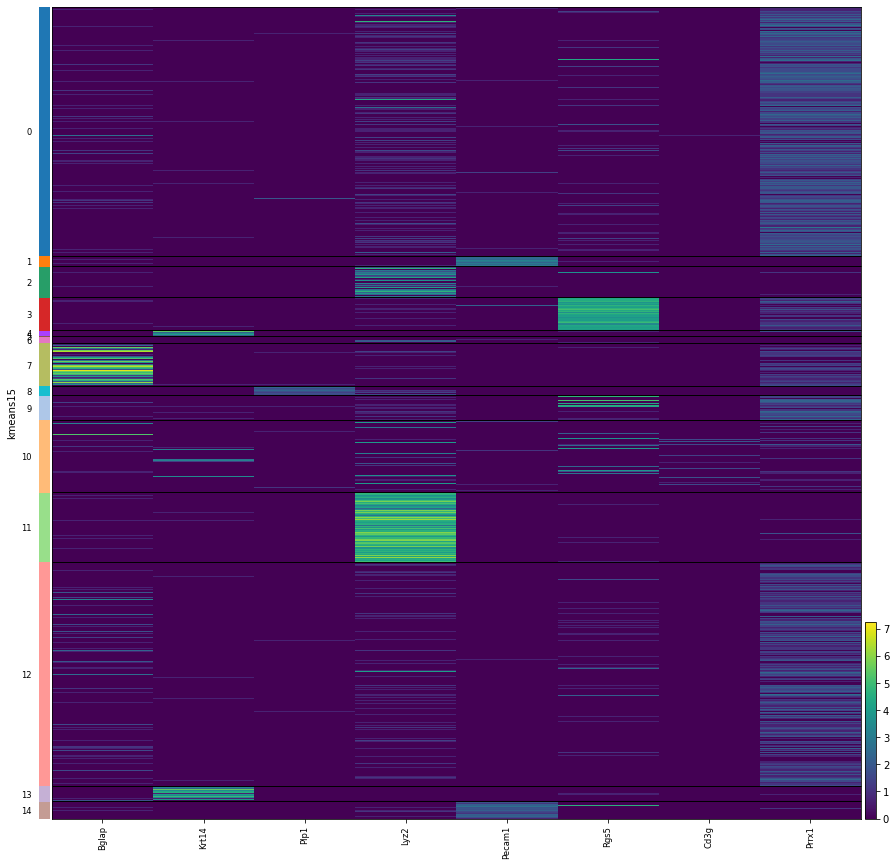

In [100]:
sc.pl.heatmap(adata_12dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans15', figsize=(15,15))

__gene - cell type__  
Bglap - bone  
Krt14 - epithelium  
Plp1 - Schwann cells  
Lyz2 - macrophages  
Pecam1 - endothelium  
Rgs5 - vascular smooth muscle  
Cd3g - T cells  
Prrx1 - fibroblasts  

In [103]:
ARI_leiden_kmeans = adjusted_rand_score(adata_12dpa.obs['leiden'], adata_12dpa.obs['kmeans15'])
jaccard_leiden_kmeans = jaccard_score(adata_12dpa.obs['leiden'], adata_12dpa.obs['kmeans15'], average='weighted')
AMI_leiden_kmeans = adjusted_mutual_info_score(adata_12dpa.obs['leiden'], adata_12dpa.obs['kmeans15'])
silhouette_leiden = silhouette_score(adata_12dpa.X, adata_12dpa.obs['leiden'])
silhouette_kmeans = silhouette_score(adata_12dpa.X, adata_12dpa.obs['kmeans15'])
CHS_leiden = calinski_harabasz_score(adata_12dpa.X.toarray(), adata_12dpa.obs['leiden'])
CHS_kmeans = calinski_harabasz_score(adata_12dpa.X.toarray(), adata_12dpa.obs['kmeans15'])

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_leiden_kmeans)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_leiden_kmeans)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_leiden_kmeans)
print('Silhouette Coefficient (leiden):          ', '[-1,1]    ', silhouette_leiden)
print('Silhouette Coefficient (kmeans):          ', '[-1,1]    ', silhouette_kmeans)
print('Calinski-Harabasz Index (leiden):   ', '[-,-]     ', CHS_leiden)
print('Calinski-Harabasz Index (kmeans):         ', '[-,-]     ', CHS_leiden)
print('--------------------------------------------------------')

--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.3312717943405002
Jaccard Index:                    [0,1]      0.02571944669648523
Adjusted Mutual Information:      [0,1]      0.634701054282329
Silhouette Coefficient (leiden):           [-1,1]     -0.024682386
Silhouette Coefficient (kmeans):           [-1,1]     0.016026497
Calinski-Harabasz Index (leiden):    [-,-]      52.56971987911038
Calinski-Harabasz Index (kmeans):          [-,-]      52.56971987911038
--------------------------------------------------------


# 14dpa

In [104]:
adata_14dpa = adatas[3].copy()
adata_ua.var_names = adata_ua.var['Name']
adata_14dpa.var_names_make_unique()

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_14dpa.X = adata_14dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_14dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_14dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_14dpa.var['mt'] = adata_14dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_14dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Text(0.5, 1.0, 'percentage of mitochondrial counts')

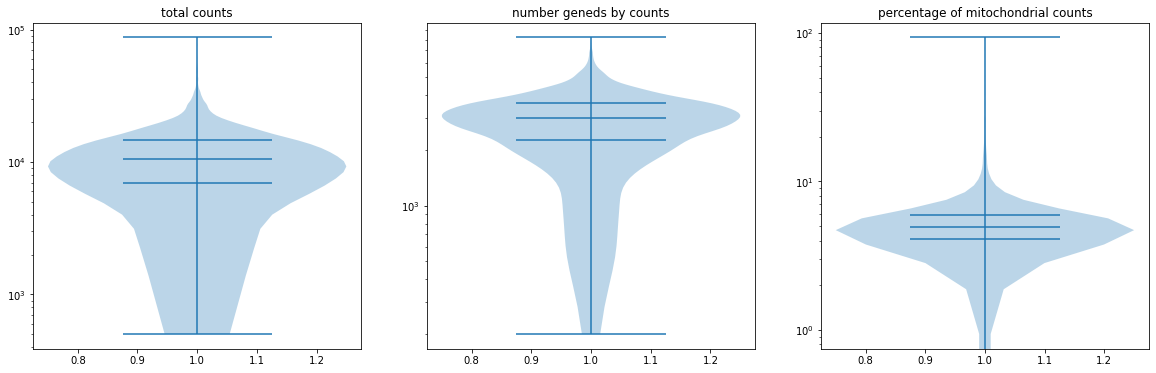

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axs[0].violinplot(adata_14dpa.obs['total_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[0].set_yscale('log')
axs[0].set_title('total counts')
axs[1].violinplot(adata_14dpa.obs['n_genes_by_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[1].set_yscale('log')
axs[1].set_title('number geneds by counts')
axs[2].violinplot(adata_14dpa.obs['pct_counts_mt'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[2].set_yscale('log')
axs[2].set_title('percentage of mitochondrial counts')

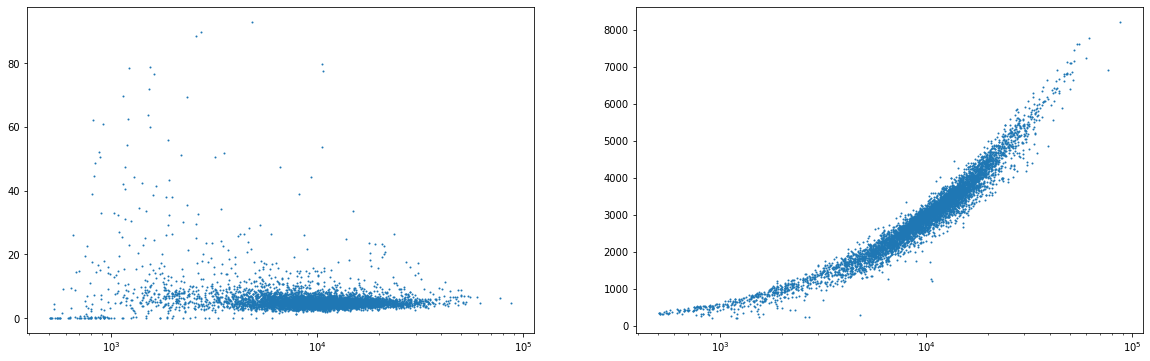

In [106]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axs[0].scatter(x=adata_14dpa.obs['total_counts'], y = adata_14dpa.obs['pct_counts_mt'], s=1)
axs[0].set_xscale('log')
axs[1].scatter(x=adata_14dpa.obs['total_counts'], y = adata_14dpa.obs['n_genes_by_counts'], s=1)
axs[1].set_xscale('log')

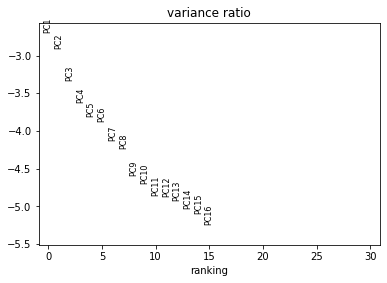

In [107]:
adata_14dpa.obs['n_genes_by_counts_filter'] = adata_14dpa.obs.n_genes_by_counts > 2000
adata_14dpa.obs['pct_counts_mt_filter'] = adata_14dpa.obs.pct_counts_mt < 15

sc.pp.log1p(adata_14dpa)
sc.pp.highly_variable_genes(adata_14dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_14dpa_hvg = adata_14dpa[:, adata_14dpa.var['highly_variable'] == True]
adata_14dpa_hvg.raw = adata_14dpa
sc.pp.scale(adata_14dpa_hvg)
sc.pp.pca(adata_14dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_14dpa_hvg)
sc.pl.pca_variance_ratio(adata_14dpa_hvg, log=True)

## Clustering¶
### Visualizing marker genes

... storing 'Name' as categorical


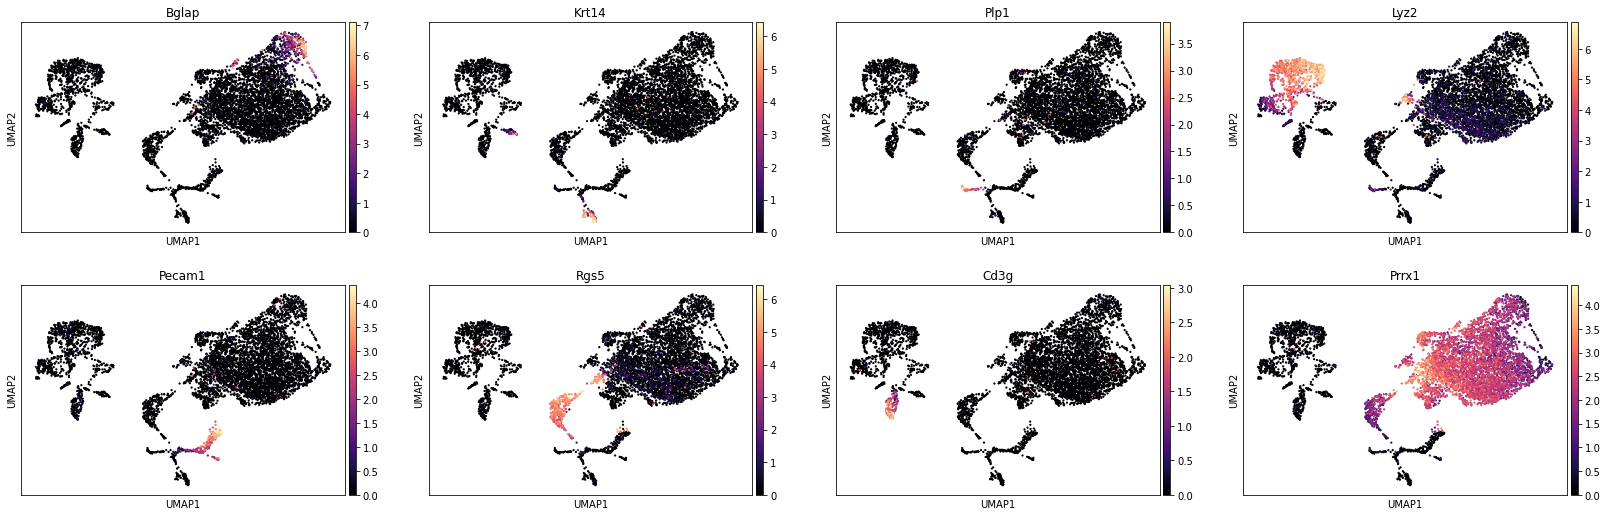

In [108]:
sc.pp.pca(adata_14dpa)
sc.pp.neighbors(adata_14dpa)
sc.tl.umap(adata_14dpa)
sc.pl.umap(adata_14dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [109]:
sc.tl.leiden(adata_14dpa_hvg, resolution=0.6)
adata_14dpa.obs['leiden'] = adata_14dpa_hvg.obs['leiden']

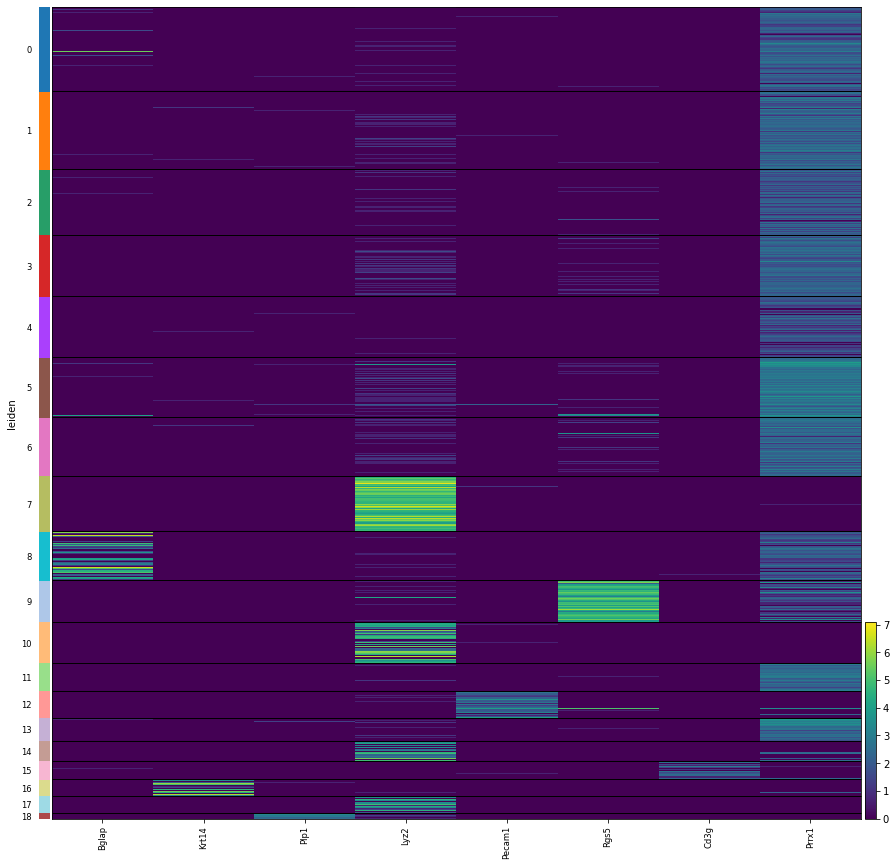

In [110]:
sc.pl.heatmap(adata_14dpa, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15))

### K-means clustering

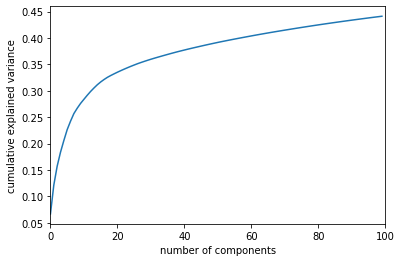

In [111]:
explained_variance_ratio(adata_14dpa_hvg)

In [112]:
reduced_data_14dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_14dpa_hvg.X)

In [113]:
kmeans = KMeans(n_clusters=19, random_state=0).fit(reduced_data_14dpa_hvg) 
adata_14dpa.obs['kmeans19'] = kmeans.labels_.astype(str)

... storing 'kmeans19' as categorical


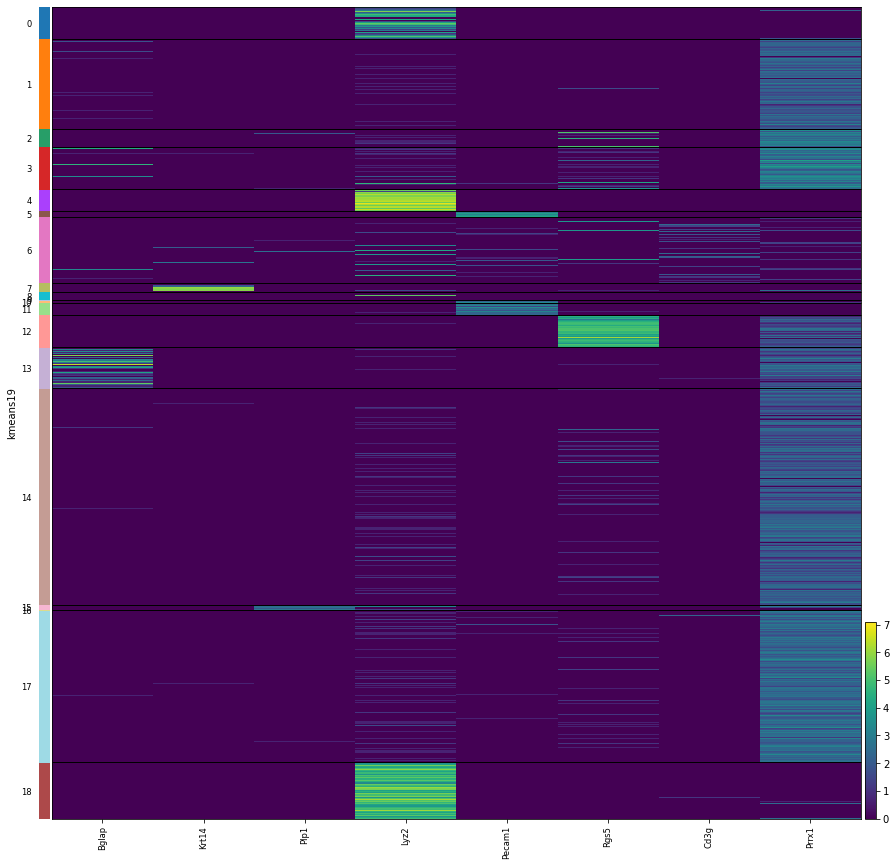

In [114]:
sc.pl.heatmap(adata_14dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans19', figsize=(15,15))

__gene - cell type__  
Bglap - bone  
Krt14 - epithelium  
Plp1 - Schwann cells  
Lyz2 - macrophages  
Pecam1 - endothelium  
Rgs5 - vascular smooth muscle  
Cd3g - T cells  
Prrx1 - fibroblasts  

In [115]:
ARI_leiden_kmeans = adjusted_rand_score(adata_14dpa.obs['leiden'], adata_14dpa.obs['kmeans19'])
jaccard_leiden_kmeans = jaccard_score(adata_14dpa.obs['leiden'], adata_14dpa.obs['kmeans19'], average='weighted')
AMI_leiden_kmeans = adjusted_mutual_info_score(adata_14dpa.obs['leiden'], adata_14dpa.obs['kmeans19'])
silhouette_leiden = silhouette_score(adata_14dpa.X, adata_14dpa.obs['leiden'])
silhouette_kmeans = silhouette_score(adata_14dpa.X, adata_14dpa.obs['kmeans19'])
CHS_leiden = calinski_harabasz_score(adata_14dpa.X.toarray(), adata_14dpa.obs['leiden'])
CHS_kmeans = calinski_harabasz_score(adata_14dpa.X.toarray(), adata_14dpa.obs['kmeans19'])

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_leiden_kmeans)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_leiden_kmeans)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_leiden_kmeans)
print('Silhouette Coefficient (leiden):          ', '[-1,1]    ', silhouette_leiden)
print('Silhouette Coefficient (kmeans):          ', '[-1,1]    ', silhouette_kmeans)
print('Calinski-Harabasz Index (leiden):   ', '[-,-]     ', CHS_leiden)
print('Calinski-Harabasz Index (kmeans):         ', '[-,-]     ', CHS_leiden)
print('--------------------------------------------------------')

--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.33645780210615106
Jaccard Index:                    [0,1]      0.0035383006503592134
Adjusted Mutual Information:      [0,1]      0.6172804028436679
Silhouette Coefficient (leiden):           [-1,1]     -0.027077405
Silhouette Coefficient (kmeans):           [-1,1]     0.035955545
Calinski-Harabasz Index (leiden):    [-,-]      99.0523807333452
Calinski-Harabasz Index (kmeans):          [-,-]      99.0523807333452
--------------------------------------------------------


# 17dpa

In [116]:
adata_17dpa = adatas[4].copy()
adata_ua.var_names = adata_ua.var['Name']
adata_17dpa.var_names_make_unique()

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_17dpa.X = adata_17dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_17dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_17dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_17dpa.var['mt'] = adata_17dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_17dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Text(0.5, 1.0, 'percentage of mitochondrial counts')

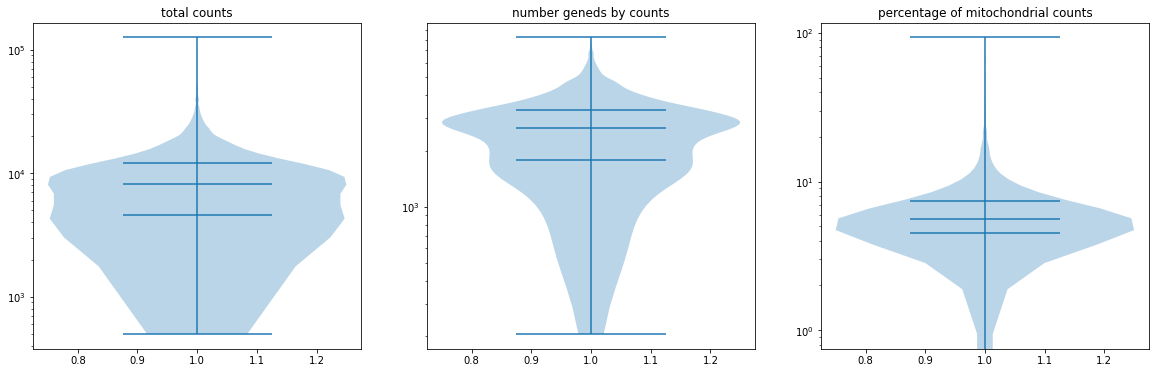

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axs[0].violinplot(adata_17dpa.obs['total_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[0].set_yscale('log')
axs[0].set_title('total counts')
axs[1].violinplot(adata_17dpa.obs['n_genes_by_counts'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[1].set_yscale('log')
axs[1].set_title('number geneds by counts')
axs[2].violinplot(adata_17dpa.obs['pct_counts_mt'], showmeans=False, showextrema=True, showmedians=False, quantiles=[.25, .5, .75], points=100, bw_method=None)
axs[2].set_yscale('log')
axs[2].set_title('percentage of mitochondrial counts')

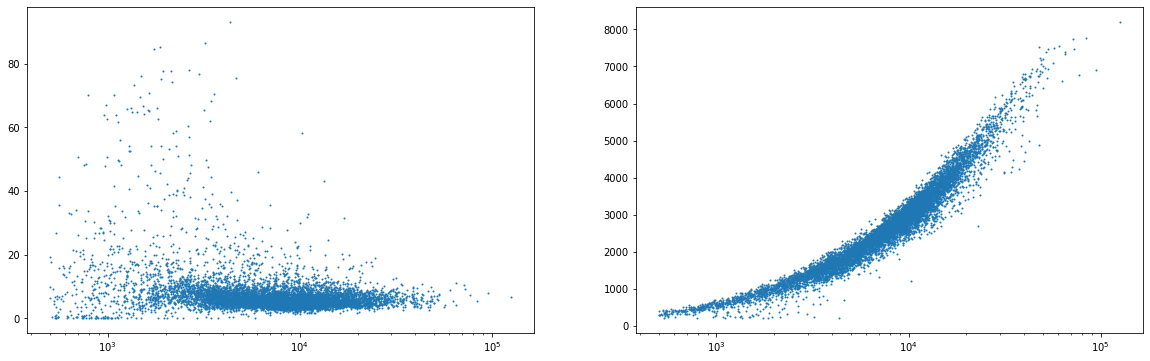

In [118]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axs[0].scatter(x=adata_17dpa.obs['total_counts'], y = adata_17dpa.obs['pct_counts_mt'], s=1)
axs[0].set_xscale('log')
axs[1].scatter(x=adata_17dpa.obs['total_counts'], y = adata_17dpa.obs['n_genes_by_counts'], s=1)
axs[1].set_xscale('log')

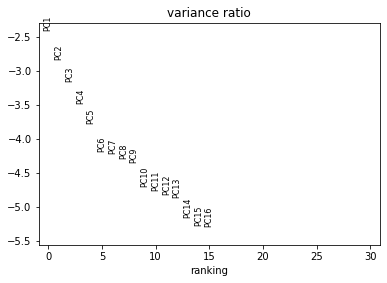

In [119]:
adata_17dpa.obs['n_genes_by_counts_filter'] = adata_17dpa.obs.n_genes_by_counts > 1000
adata_17dpa.obs['pct_counts_mt_filter'] = adata_17dpa.obs.pct_counts_mt < 20

sc.pp.log1p(adata_17dpa)
sc.pp.highly_variable_genes(adata_17dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_17dpa_hvg = adata_17dpa[:, adata_17dpa.var['highly_variable'] == True]
adata_17dpa_hvg.raw = adata_17dpa
sc.pp.scale(adata_17dpa_hvg)
sc.pp.pca(adata_17dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_17dpa_hvg)
sc.pl.pca_variance_ratio(adata_17dpa_hvg, log=True)

## Clustering
### Visualizing marker genes

... storing 'Name' as categorical


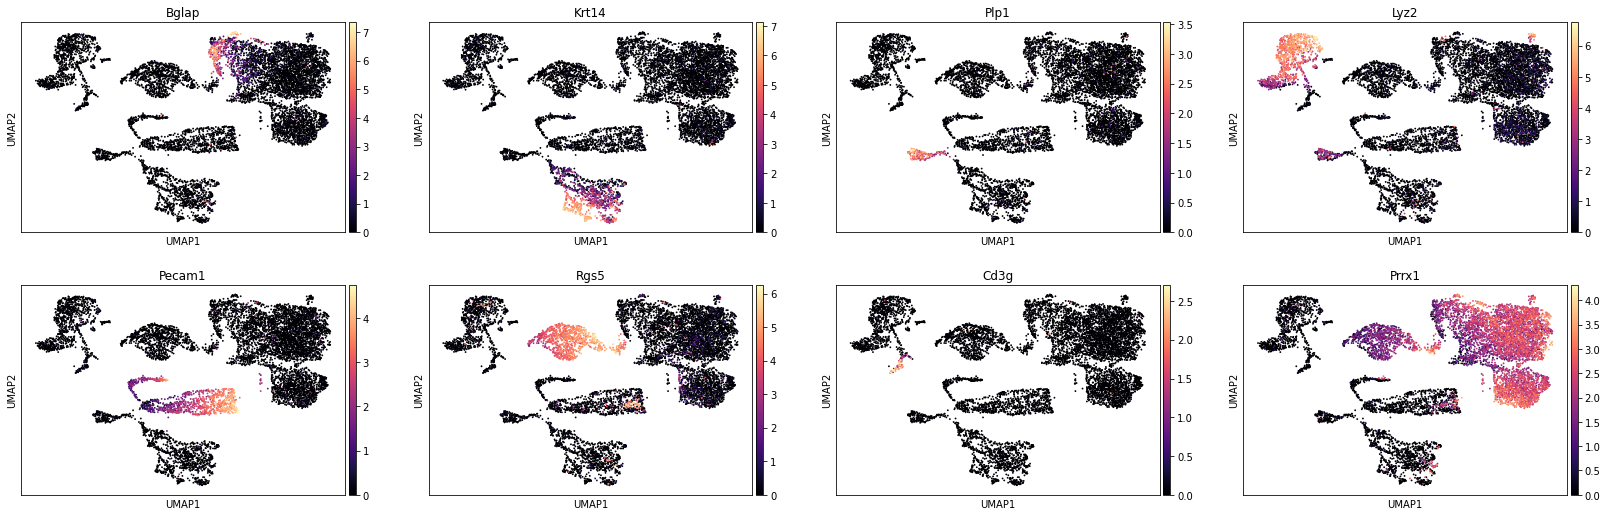

In [120]:
sc.pp.pca(adata_17dpa)
sc.pp.neighbors(adata_17dpa)
sc.tl.umap(adata_17dpa)
sc.pl.umap(adata_17dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [121]:
sc.tl.leiden(adata_17dpa_hvg, resolution=0.6)
adata_17dpa.obs['leiden'] = adata_17dpa_hvg.obs['leiden']

### K-means clustering

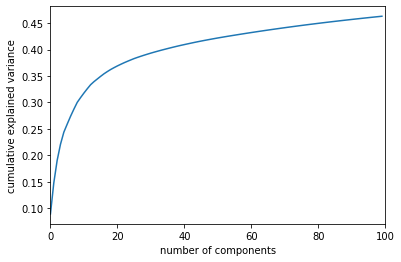

In [122]:
explained_variance_ratio(adata_17dpa_hvg)

In [123]:
reduced_data_17dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_17dpa_hvg.X)

In [124]:
kmeans = KMeans(n_clusters=17, random_state=0).fit(reduced_data_17dpa_hvg) 
adata_17dpa.obs['kmeans17'] = kmeans.labels_.astype(str)

... storing 'kmeans17' as categorical


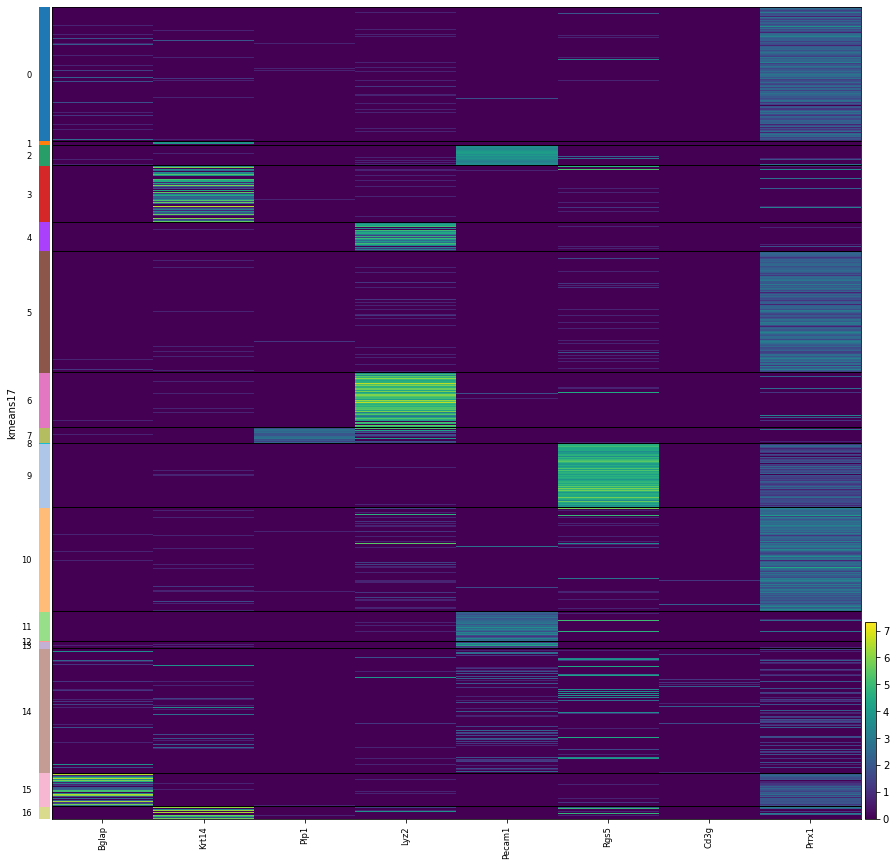

In [125]:
sc.pl.heatmap(adata_17dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans17', figsize=(15,15))

__gene - cell type__  
Bglap - bone  
Krt14 - epithelium  
Plp1 - Schwann cells  
Lyz2 - macrophages  
Pecam1 - endothelium  
Rgs5 - vascular smooth muscle  
Cd3g - T cells  
Prrx1 - fibroblasts  

In [126]:
ARI_leiden_kmeans = adjusted_rand_score(adata_17dpa.obs['leiden'], adata_17dpa.obs['kmeans17'])
jaccard_leiden_kmeans = jaccard_score(adata_17dpa.obs['leiden'], adata_17dpa.obs['kmeans17'], average='weighted')
AMI_leiden_kmeans = adjusted_mutual_info_score(adata_17dpa.obs['leiden'], adata_17dpa.obs['kmeans17'])
silhouette_leiden = silhouette_score(adata_17dpa.X, adata_17dpa.obs['leiden'])
silhouette_kmeans = silhouette_score(adata_17dpa.X, adata_17dpa.obs['kmeans17'])
CHS_leiden = calinski_harabasz_score(adata_17dpa.X.toarray(), adata_17dpa.obs['leiden'])
CHS_kmeans = calinski_harabasz_score(adata_17dpa.X.toarray(), adata_17dpa.obs['kmeans17'])

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_leiden_kmeans)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_leiden_kmeans)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_leiden_kmeans)
print('Silhouette Coefficient (leiden):          ', '[-1,1]    ', silhouette_leiden)
print('Silhouette Coefficient (kmeans):          ', '[-1,1]    ', silhouette_kmeans)
print('Calinski-Harabasz Index (leiden):   ', '[-,-]     ', CHS_leiden)
print('Calinski-Harabasz Index (kmeans):         ', '[-,-]     ', CHS_leiden)
print('--------------------------------------------------------')

--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.5352089288745518
Jaccard Index:                    [0,1]      0.07158489890026362
Adjusted Mutual Information:      [0,1]      0.7254274242990572
Silhouette Coefficient (leiden):           [-1,1]     -0.026942307
Silhouette Coefficient (kmeans):           [-1,1]     0.02797547
Calinski-Harabasz Index (leiden):    [-,-]      178.04256235116716
Calinski-Harabasz Index (kmeans):          [-,-]      178.04256235116716
--------------------------------------------------------
